### Imports

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp

# The other more specific imports are under the corresponding section

# Determination of the sentiment analysis method (Milestone 2)

This is a recap of the milestone 2. The whole analysis for the determination of the sentiment method is in the ```main_milestone2.ipynb``` notebook

- In this project, we aim to describe and analyze data based on a sentiment associated to each Wikispeedia page. To do so, we believe that our analyses will strongly depend on the sentiment annotation method. Therefore, in this first part, we extensively explore the different methods of sentiment annotation. 
- By "sentiment annotation", we mean that each article will be given a score for its content. A sentiment score $s\in[-1,1]$ where $s=1$ (respectively, $s=0$, $s=-1$) means an article is associated to a positive (respectively, neutral, negative) sentiment.
##### After trying out different methods with validation data (cf notebook main_milestone2), the following model was chosen
Large language model ([Roberta for sentiment analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)) (A Robustly Optimised BERT Pre-training Approach): RoBERTa is a large language model (Meta Research), which is trained on a vast corpus of data for self-supervised natural language processing. It performs binary sentiment analysis, categorising text as either positive or negative. RoBERTa has been fine-tuned on millions of tweets, making it suitable to detect sentiment.

### Roberta for sentiment analysis

For practical purposes, we do not run Roberta in this notebook. We have done it in a machine with sufficient memory to infer the predictions on the validation data, which we load and show below. The notebook used is ```sentiment_analysis_5.ipynb```.

In [42]:
preds = np.array([-0.75, 0.62, -0.71, -0.85, 0.42, 0.56, -0.81, 0.65, 0.42, 0.58, 0.57, 0.21, -0.62, -0.44, 0.36, -0.64, -0.8, 0.58, 0.53, -0.86, -1, 0.43, 0.43, -0.93, -0.94, 0.39, -0.82, -0.55, 0.49, 0.86, -0.53, 0.65, -0.96, 0.61, 0.58])

The mean square error of the model on the validation articles is 0.35532857142857144


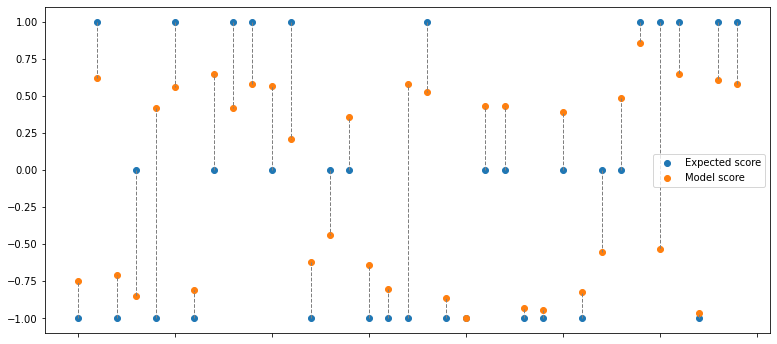

In [43]:
expected_score=np.array([-1,1,-1,0,-1,1,-1,0,1,1,0,1,-1,0,0,-1,-1,-1,1,-1,-1,0,0,-1,-1,0,-1,0,0,1,1,1,-1,1,1])
model_score=preds

errors=expected_score-model_score

x=np.arange(len(expected_score))

fig,ax=plt.subplots(1,figsize=(13,6))

ax.scatter(x,expected_score,label='Expected score')
ax.scatter(x,model_score,label='Model score')

for i in range(len(x)):
    ax.plot([x[i],x[i]],[expected_score[i],model_score[i]],color='gray',linestyle='--',linewidth=1)

ax.set_xticklabels([])
ax.legend()

mse=np.mean(np.square(errors))

print(f'The mean square error of the model on the validation articles is {mse}')

## II. Some initial analyses and initial loading pipelines for player paths
In order to run this part, you need to download the `wikispeedia_paths-and-graph.tar.gz` and `wikispeedia_articles_plaintext.tar.gz` from [here](https://snap.stanford.edu/data/wikispeedia.html) , extract them and put them in the ```data``` folder which should be in the same folder as this project.

### 1. Load and reformat the data

Loading the data of finished path

In [7]:
file_path = '../data/paths_finished.tsv'
df_finished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
df_finished.columns = cols
df_finished['target'] = df_finished['path'].apply(lambda x: x.split(';')[-1])
df_finished['type'] = 'finished'
df_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,type
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,finished
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,finished
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,finished
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,finished
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,finished


Loading the data of unfinished path

file_path = '../data/paths_unfinished.tsv'
df_unfinished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
df_unfinished.columns = cols
df_unfinished.head()

merge them together

In [10]:
df = pd.concat([df_finished, df_unfinished], axis=0)
df['start'] = df['path'].apply(lambda x: x.split(';')[0])
df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,type,start
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African_slave_trade,finished,14th_century
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African_slave_trade,finished,14th_century
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African_slave_trade,finished,14th_century
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,finished,14th_century
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John_F._Kennedy,finished,14th_century


load the articles(nodes) and links between them(edges)

In [12]:
file_path = '../data/links.tsv'
df_links = pd.read_csv(file_path, sep='\t', header=None)
df_links.head()

,0,1
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [14]:
articles = pd.read_csv('../data/articles.tsv', sep='\t', header=None)

### 2. Some Statistics and visualizations

- basics

In [16]:
print('Number of games played: {}, with {:.2f}% finished rate'.format(len(df), len(df_finished)/len(df)*100))
print('Number of participated individuals: {}'.format(len(df['hashedIpAddress'].unique())))
used_articles = set([item for sublist in df['path'].apply(lambda x: x.split(';')) for item in sublist])
print('Number of articles: {}, {:.2f}% are covered in the game'.format(len(articles), len(used_articles)/len(articles)*100))
print('Number of edges: {}, with average degree {:.0f}'.format(len(df_links), len(df_links)/len(articles)))

Number of games played: 76193, with 67.35% finished rate
Number of participated individuals: 20868
Number of articles: 4604, 90.86% are covered in the game
Number of edges: 119882, with average degree 26


- Degree distribution analysis
Consider that every edge is bidirectional because the user can go back through the back button.

In [17]:
# calculate the degree of each article
articles.columns = ['article']
# left join to get the degree of each article
degree_out = df_links.groupby(0).count().reset_index()
degree_out.columns = ['article', 'degree_out']
degree_in = df_links.groupby(1).count().reset_index()
degree_in.columns = ['article', 'degree_in']
articles = articles.merge(degree_out, on='article', how='left').fillna(0).merge(degree_in, on='article', how='left').fillna(0)
articles['degree'] = articles['degree_out'] + articles['degree_in']
articles.describe()

,degree_out,degree_in,degree
count,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,52.077324
std,24.201491,62.746827,78.551771
min,0.000000,0.000000,0.000000
25%,11.000000,2.000000,16.000000
50%,19.000000,8.000000,30.000000
75%,33.000000,25.000000,59.000000
max,294.000000,1551.000000,1845.000000


In [18]:
# print top 5 articles with highest degree
articles.sort_values('degree', ascending=False).head()

,article,degree_out,degree_in,degree
4297,United_States,294.0,1551.0,1845.0
4293,United_Kingdom,168.0,972.0,1140.0
1433,Europe,159.0,933.0,1092.0
1568,France,85.0,959.0,1044.0
1385,England,172.0,751.0,923.0


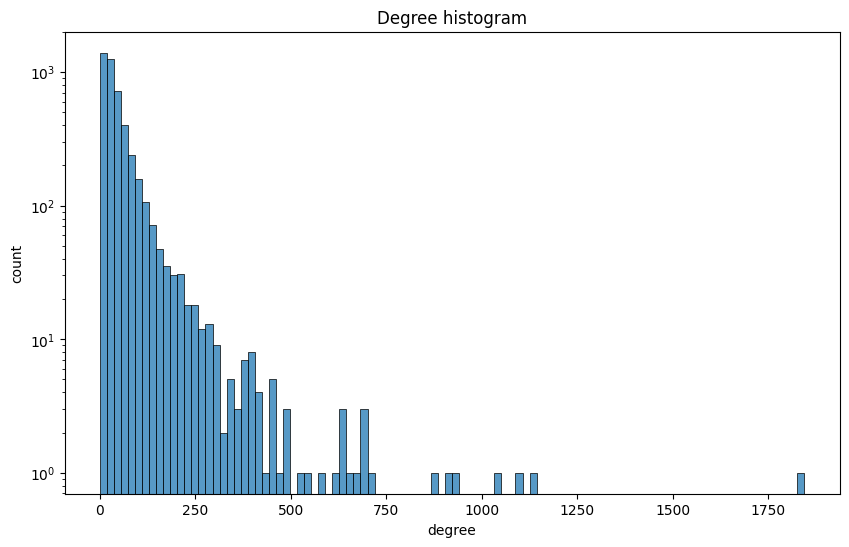

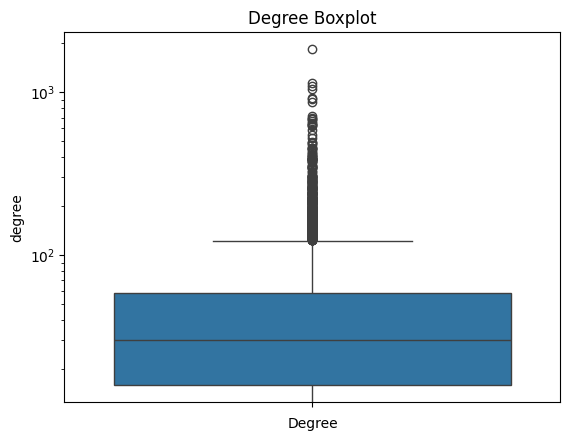

In [19]:
# plot the hist degree distribution with logy scale
plt.figure(figsize=(10, 6))
sns.histplot(articles['degree'], kde=False, bins=100)
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('count')
plt.title('Degree histogram')
plt.show()

sns.boxplot(articles['degree'])
plt.xlabel('Degree')  
plt.title('Degree Boxplot') 
plt.yscale('log')
plt.show()

- path length distribution anlysis

In [20]:
df['path_length'] = df['path'].apply(lambda x: len(x.split(';')))
df['path_length'].describe()

count    76193.000000
mean         6.248251
std          5.115519
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max        435.000000
Name: path_length, dtype: float64

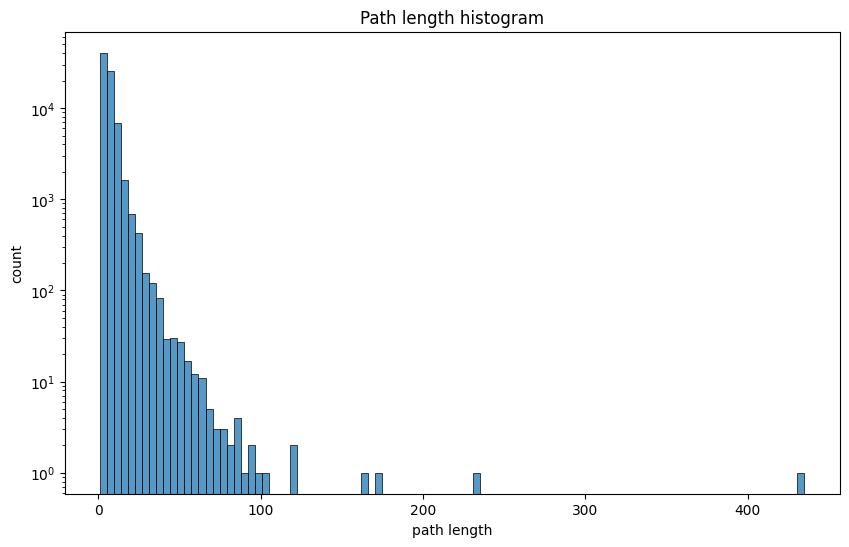

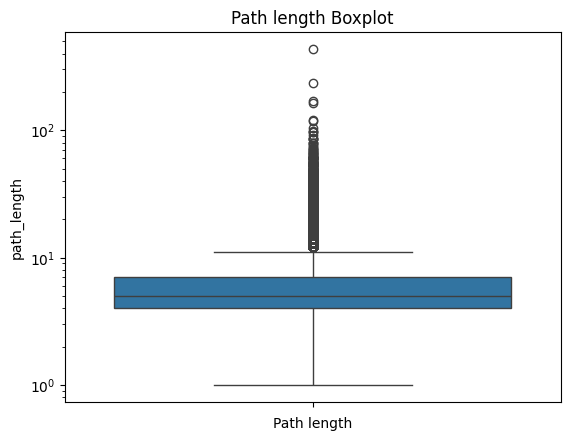

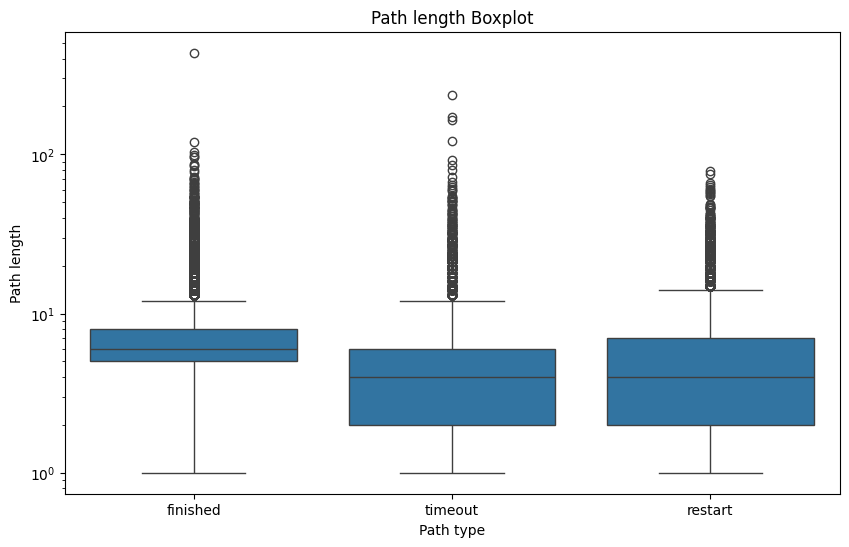

In [21]:
# plot the hist path length distribution and boxplot
plt.figure(figsize=(10, 6))
sns.histplot(df['path_length'], kde=False, bins=100)
plt.yscale('log')
plt.xlabel('path length')
plt.ylabel('count')
plt.title('Path length histogram')
plt.show()

sns.boxplot(df['path_length'])
plt.xlabel('Path length')
plt.title('Path length Boxplot')
plt.yscale('log')
plt.show()

# 2 boxplot with finished and unfinished paths
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='path_length', data=df)
plt.yscale('log')
plt.xlabel('Path type')
plt.ylabel('Path length')
plt.title('Path length Boxplot')
plt.show()

- relation between a frequently visited article it's degree
For this we first calculate the frequency of each article in the paths, then we comparing with the degree of each article and calculate the correlation. the < value is substituted with the previous previous article in the path.

In [22]:
def replace_lt_with_previous(article_path):
    path_elements = article_path.split(';')
    for i, element in enumerate(path_elements):
        if element == '<' and i > 1:
            path_elements[i] = path_elements[i-2]
    return ';'.join(path_elements)

df['path'] = df['path'].apply(replace_lt_with_previous)

# count the frequency of each article
article_freq = pd.DataFrame(df['path'].apply(lambda x: x.split(';')).explode().value_counts()).reset_index()
articles_cnt = pd.merge( articles, article_freq, left_on='article', right_on='path', how='left').fillna(0)
# drop path column
articles_cnt.drop('path', axis=1, inplace=True)
articles_cnt['count'].describe()

count     4604.000000
mean       103.404214
std        339.894277
min          0.000000
25%         15.000000
50%         34.000000
75%         81.000000
max      13617.000000
Name: count, dtype: float64

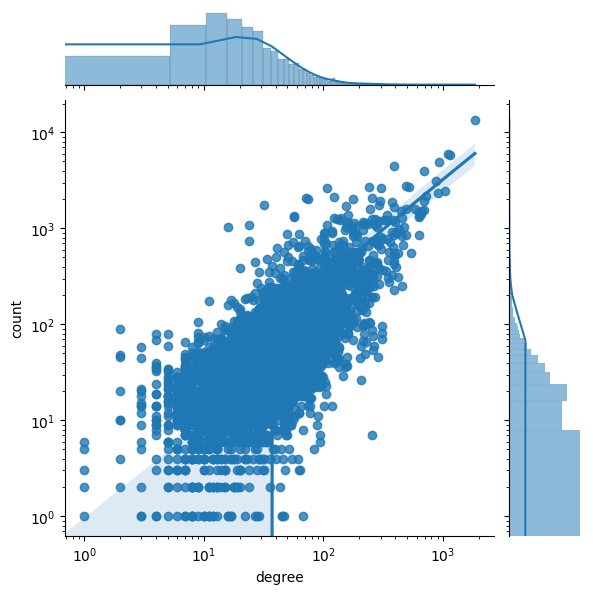

In [23]:
sns.jointplot(x='degree', y='count', data=articles_cnt, kind='reg')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [24]:
# test if the degree and count are correlated
from scipy.stats import pearsonr
pearsonr(articles_cnt['degree'], articles_cnt['count'])

PearsonRResult(statistic=0.765211321722257, pvalue=0.0)

It's obvious that the degree and count are highly correlated, which means that the higher degree it has, the more he frequent an article is visited in the game

- analysis of the the path length in the game and the theoretical shortest path length
we only consider the finished paths here because we don't know how long will it expected to be when the unfinished path is completed.
*it's noticed that there is one row in the game that the user can finish it by one click but the shortest path length is none according to the data, the reason of that has to be investigated later*

In [25]:
file_path = '../data/shortest-path-distance-matrix.txt'
df_shortest_path = pd.read_csv(file_path, sep='\t', header=None)


def find_p(row):
    start_idx = articles[articles['article'] == row['start']].index
    target_idx = articles[articles['article'] == row['target']].index
    if(row['type'] != 'finished'):
        return -1
    if not start_idx.empty and not target_idx.empty:

        start_idx = start_idx[0]
        target_idx = target_idx[0]

        s = df_shortest_path.iloc[start_idx][0]

        return 0 if s[target_idx] == '_' else int(s[target_idx])
    else:
        print(row['start'], row['target'],row['type'],row['path'])
        return 0

df['shortest_path'] = df.apply(find_p, axis=1)

PearsonRResult(statistic=0.20097957001845854, pvalue=0.0)

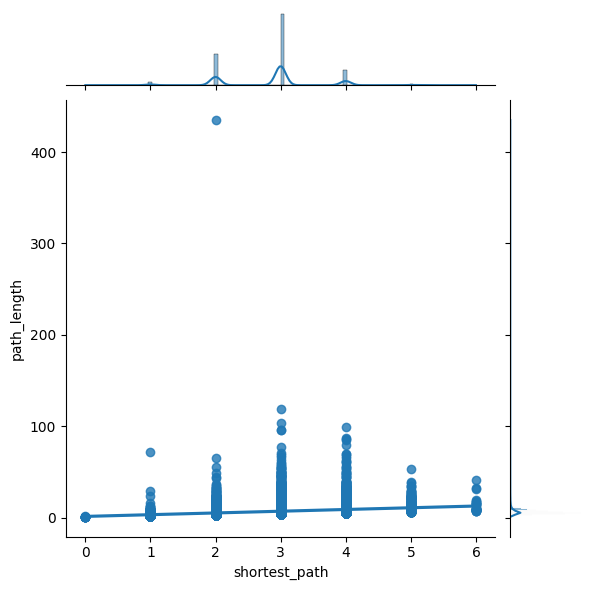

In [26]:
sns.jointplot(x='shortest_path', y='path_length', data=df[df['type'] == 'finished'], kind='reg')

pearsonr(df['shortest_path'], df['path_length'])

# Data analysis, answer to the 5 subquestions (Milestone 3)

# Paths conversion

This first part convert the paths to scores path using the scores from the Roberta model. As there are several different subquestions, the final dataframe can be different depending on the analysis that are performed. There is therefore different methods to convert the dataframe, which can be chosen in this notebook.

### Imports

In [ ]:
from utils import read_pickle,preprocess
from methods import method1_1,method1_2,method2_1,method2_2

## Scores analysis

The first step is to load the initial scores from the pickle file

In [ ]:
headers=['Article','Negative','Neutral','Positive']
df1=read_pickle(headers)

positive_words=set(open('./Positive words 4.txt').read().splitlines())
negative_words=set(open('./Negative words 4.txt').read().splitlines())

df1.head()

,Article,Negative,Neutral,Positive
0,Matter,0.235663,0.668916,0.095422
1,Common_Tern,0.152064,0.750734,0.097202
2,Restoration_literature,0.169710,0.697821,0.132469
3,European_Kingfisher,0.076588,0.791261,0.132150
4,Abuja,0.119582,0.672143,0.208275


As Roberta output are positive, neutral and negative score, they need to be converted into a single score between [-1,1]. The adjusted score can be calculated with different methods, as shown in the function below. A new dataframe with the article and the calculated score is created for each methods. All the methods and imported from and described in the methods.py script.

In [ ]:
def adjust_scores(df,method=1):
    '''
    Calculate the final score from the roberta output
    :param df: dataframe with the positive, neutral and negative scores
    :param method: number of the method used
    '''
    for i in range(len(df)):

        path=f'./plaintext_articles/{df.loc[i,"Article"]}.txt'
        
        with open(path,'r') as file:
            text=file.read()
        
        text=preprocess(text)
        
        pos=df.loc[i,'Positive']
        neg=df.loc[i,'Negative']
        

        if method==1:
            final_score=method1_1(text,pos-neg,positive_words,negative_words,0.5)
        
        if method==2:
            final_score=method1_2(pos,neg)

        df.loc[i,'Score']=final_score

    return df

In [ ]:
df_scores1=adjust_scores(df1)[['Article','Score']].copy(deep=True)
df_scores2=adjust_scores(df1,2)[['Article','Score']].copy(deep=True)

pd.concat([df_scores1.head(),df_scores2.head()],axis=1)

,Article,Score,Article,Score
0,Matter,-0.140241,Matter,-0.595093
1,Common_Tern,-0.054862,Common_Tern,-0.360784
2,Restoration_literature,-0.037241,Restoration_literature,-0.219439
3,European_Kingfisher,0.055562,European_Kingfisher,0.420446
4,Abuja,0.088693,Abuja,0.425846


To get a visual of the scores mapping, a histogram is plotted.

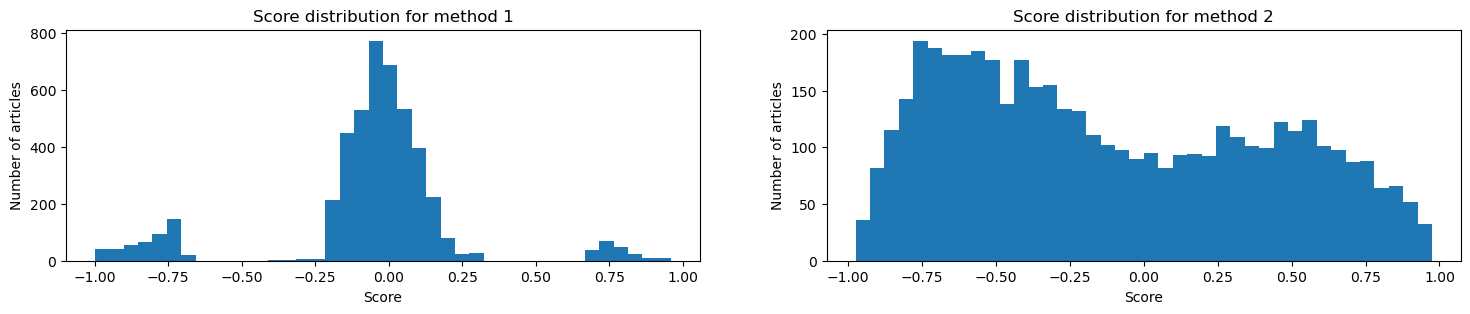

In [ ]:
arr_score=[df_scores1['Score'].values,df_scores2['Score'].values]

fig,ax=plt.subplots(1,2,figsize=(18,3))

for i in range(len(arr_score)):
    ax[i].hist(arr_score[i],40)
    ax[i].set_xlabel('Score')
    ax[i].set_ylabel('Number of articles')
    ax[i].set_title(f'Score distribution for method {i+1}')

In [ ]:
pos_count=len(df_scores1[df_scores1['Score']>=0.5])
neg_count=len(df_scores1[df_scores1['Score']<=-0.5])
neutral_count=len(df_scores1[(df_scores1['Score']>-0.5) & (df_scores1['Score']<0.5)])

print(f'{pos_count} positive articles ({round(100*pos_count/len(df_scores1))} %) \n{neg_count} negative articles ({round(100*neg_count/len(df_scores1))} %) \n{neutral_count} neutral articles ({round(100*neutral_count/len(df_scores1))} %)')

196 positive articles (4 %) 
461 negative articles (10 %) 
3947 neutral articles (86 %)


The first method not really selective (86% of the articles are considered neutral), but is highly separative (all articles can clearly be labelled as either positive, neutral or negative).
The second method is less separative and more equally distributive.
For now, the first method will be used, as it performed well on validation data (see previous part).

As the first method is highly separative, the labels (Positive, Neutral or Negative) and their corresponding scores (1,0,-1) are added in the dataframe.

In [ ]:
conditions = [(df_scores1['Score'] > 0.5),(df_scores1['Score'] >= -0.5) & (df_scores1['Score'] <= 0.5),(df_scores1['Score'] < -0.5)]
choices1 = ['Positive', 'Neutral', 'Negative']
choices2 = [1,0,-1]
df_scores1['Label'] = np.select(conditions, choices1, default='Undefined')
df_scores1['Rounded'] = np.select(conditions, choices2, default='Undefined')

df_scores1['Rounded']=df_scores1['Rounded'].astype(int)

df_scores1[:10]

,Article,Score,Label,Rounded
0,Matter,-0.140241,Neutral,0
1,Common_Tern,-0.054862,Neutral,0
2,Restoration_literature,-0.037241,Neutral,0
3,European_Kingfisher,0.055562,Neutral,0
4,Abuja,0.088693,Neutral,0
5,Dublin,0.141195,Neutral,0
6,Bassoon,0.108070,Neutral,0
7,Indian_Institutes_of_Technology,0.079594,Neutral,0
8,Baroque,0.106084,Neutral,0
9,Myanmar,0.299302,Neutral,0


## Path analysis

The finished and unfinished paths are loaded, assembled and rearranged for the task of interest.

In [ ]:
df_f_paths=pd.read_csv('./wikispeedia_paths-and-graph/paths_finished.tsv',sep='\t',skiprows=16,names=['hashedIpAddress','timestamp','durationInSec','Path','rating'])
df_uf_paths=pd.read_csv('./wikispeedia_paths-and-graph/paths_unfinished.tsv',sep='\t',skiprows=16,names=['hashedIpAddress','timestamp','durationInSec','Path','Target','type'])

df_f_paths=df_f_paths[['Path']].copy(deep=True)
df_uf_paths=df_uf_paths[['Path','Target']].copy(deep=True)

df_paths=pd.concat([df_f_paths,df_uf_paths],axis=0,ignore_index=True,sort=False)

df_paths=pd.DataFrame(df_paths)
print(f'There is {len(df_paths)} paths')
df_paths.head()

There is 76193 paths


,Path,Target
0,14th_century;15th_century;16th_century;Pacific...,NaN
1,14th_century;Europe;Africa;Atlantic_slave_trad...,NaN
2,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,NaN


The paths are in string and article form. We create a function that transforms these in score and label paths.

- First method: Remove the articles that the players come back from, as to get only the direct path from the starting article to the target.

- Second method: Keep all the articles, have the whole path with the comebacks

In both methods, the articles next to each other are (hopefully) semantically linked, as the comebacks are just the reverse of the choices a player did. Therefore, both methods are valid, but can be used for different analysis.

In the oscillating path analysis for example, we would like to get rid of the comebacks, as they could incurr false results. (we want to observe oscillation between different articles, not between two articles going back and forth).

In [ ]:
def transform_path(path,df=df_scores1,method=1):
    '''
    Add the corresponding scores and rounded scores paths
    :param path: the initial string of articles (separated by ;)
    :param df: the score dataframe used to convert
    :param method: number of the method used
    '''
    
    if method==1:
        list1=method2_1(path)

    elif method==2:
        list1=method2_2(path)

    scores=[]
    labels=[]
    pass
    for article in list1:
        scores.append(df.loc[df['Article']==article,'Score'].values[0])
        labels.append(df.loc[df['Article']==article,'Rounded'].values[0])

    return scores,labels


def transform_df(initial_df,df_score=df_scores1,method=1):
    '''
    Perform the paths transformation on the dataframe
    :param initial_df: dataframe to convert
    :param df_score: the score dataframe used to convert
    :param method: number of the method used
    '''
    df=initial_df.copy(deep=True)
    a=len(df)

    for i in range(a):
        if i%(a//5)==0:
            print(f'{20*(i/(a//5))} %')
        scores,labels=transform_path(df.loc[i,'Path'],df_score,method)
        df.at[i,'Scores']=scores
        df.at[i,'Rounded']=labels

    return df

And the function is now applied on all the paths.

In [ ]:
df_paths['Scores']=None
df_paths['Scores'].astype('object')
df_paths['Rounded']=None
df_paths['Rounded'].astype('object')

df_paths1=transform_df(df_paths,method=1)
df_paths2=transform_df(df_paths,method=2)

0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
100.0 %
0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
100.0 %


In [ ]:
print(f'There is {len(df_paths1)} paths for method 1 and {len(df_paths2)} paths for method 2')
df_paths1.head()

There is 76193 paths for method 1 and 76193 paths for method 2


,Path,Target,Scores,Rounded
0,14th_century;15th_century;16th_century;Pacific...,NaN,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]"
1,14th_century;Europe;Africa;Atlantic_slave_trad...,NaN,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]"
2,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]"
3,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]"
4,14th_century;Italy;Roman_Catholic_Church;HIV;R...,NaN,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]"


The target is also converted to a score, and now that all the useful information are contained as scores in the dataframe, the initial strings are removed.
During this process, we noticed that some target articles were not in the wikispeedia plaintext folder (or spelled wrong) that was analyzed to get the scores corresponding to the articles. The corresponding paths are dropped out of the analysis.


In [ ]:
df_paths_list=[df_paths1,df_paths2]
missing_articles=set()

for df in df_paths_list:

    for i in range(len(df)):
        
        target=df.loc[i,'Target']

        if target==target:
            try:
                df.loc[i,'Target score']=df_scores1.loc[df_scores1['Article']==target,'Score'].values[0]
            except:
                missing_articles.add(target)
                df.drop(index=i,inplace=True)

    df.drop(['Path','Target'],axis=1,inplace=True)
    df.reset_index(inplace=True,drop=True)


print(f'The following articles are missing: \n {missing_articles}')
df_paths1.head()

The following articles are missing: 
 {'Kashmir', 'Georgia', 'Usa', 'Christmas', 'C++', 'Podcast', 'Long_peper', 'Western_Australia', 'Bogota', 'English', 'Sportacus', 'Great', 'The', 'The_Rock', 'Macedonia', 'Rat', 'Rss', 'Black_ops_2', 'Test', '_Zebra', 'Netbook', 'Mustard', 'Adolph_Hitler', 'Fats', 'Charlottes_web'}


,Scores,Rounded,Target score
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN


Finally, the dataframe is stored in a pickle file.

In [ ]:
with open('df_paths_direct.pickle', 'wb') as file:
    pickle.dump(df_paths1, file)

with open('df_paths_undirect.pickle', 'wb') as file:
    pickle.dump(df_paths2, file)

# Question 1


Does the sentiment of the starting article influence the trajectory of the game path?
For instance, if a player begins with an article with a negative tone, are they more likely to navigate through similarly negatively toned articles?

### Imports

In [ ]:
from utils import normalize

## Data Loading and rearrangement

The first step is to load the paths (in this case from the first method), and rearrange the dataframe so that it is relevant to the question studied.

In [ ]:
with open('df_paths_direct.pickle', 'rb') as file:
    df_paths = pickle.load(file)

df_paths.head()

,Scores,Rounded,Target score
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN


The length of each path is calculated and stored in the dataframe.  
The paths that have a length of 1 are unfinished paths that do not countain any useful information for this analysis, they are therefore discarded.

In [ ]:
for i in range(len(df_paths)):
    df_paths.loc[i,'Length']=len(df_paths.loc[i,'Scores'])

df_paths['Length']=df_paths['Length'].astype(int)

df_paths=df_paths[df_paths['Length']!=1].copy(deep=True)
df_paths.reset_index(inplace=True,drop=True)

print(f'There is {len(df_paths)} paths')
df_paths.head()

There is 70280 paths


,Scores,Rounded,Target score,Length
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,9
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,5
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,8
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,4
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,7


Add a few more statistics to the dataframe.

In [ ]:
# Add the starting article score
for i in range(len(df_paths)):
    df_paths.loc[i,'Starting']=df_paths.loc[i,'Rounded'][0]

df_paths['Starting']=df_paths['Starting'].astype(int)

print('1st done')


# Add the number of positive/neutral/negative articles
for i in range(len(df_paths)):
    list2=df_paths.loc[i,'Rounded']
    df_paths.loc[i,'Pos Nbr']=list2.count(1)
    df_paths.loc[i,'Neutral Nbr']=list2.count(0)
    df_paths.loc[i,'Neg Nbr']=list2.count(-1)

df_paths['Pos Nbr']=df_paths['Pos Nbr'].astype(int)
df_paths['Neutral Nbr']=df_paths['Neutral Nbr'].astype(int)
df_paths['Neg Nbr']=df_paths['Neg Nbr'].astype(int)

print('2nd done')


# Add the positive/neutral/negative percentage of articles
df_paths['Pos %']=round(df_paths['Pos Nbr']/df_paths['Length'],2)
df_paths['Neg %']=round(df_paths['Neg Nbr']/df_paths['Length'],2)
df_paths['Neutral %']=round(df_paths['Neutral Nbr']/df_paths['Length'],2)

print('3rd done')

df_paths.head()

1st done
2nd done
3rd done


,Scores,Rounded,Target score,Length,Starting,Pos Nbr,Neutral Nbr,Neg Nbr,Pos %,Neg %,Neutral %
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,9,0,0,7,2,0.0,0.22,0.78
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,5,0,0,3,2,0.0,0.40,0.60
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,8,0,0,4,4,0.0,0.50,0.50
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,4,0,0,4,0,0.0,0.00,1.00
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,7,0,0,6,1,0.0,0.14,0.86


## Data visualisation and analysis

### Visualisation

Let's visualize the data and try to get hints about the answer.  
What we can do is specify the question:
- For a positive starting article, is it more likely to get positive articles in the corresponding path ?

Text(0, 0.5, 'Positive start')

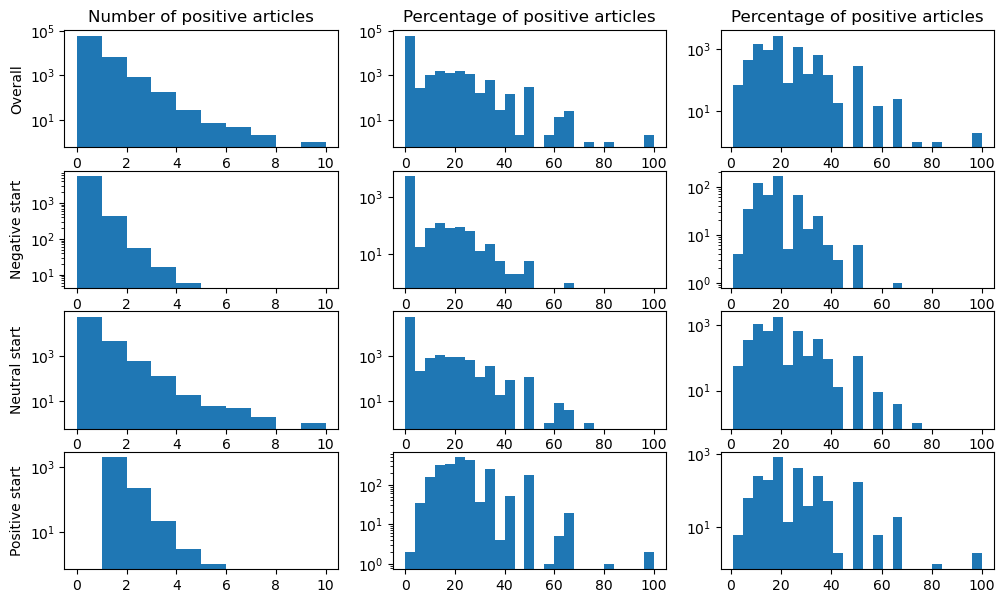

In [ ]:
arrs=[]

for col in ['Pos Nbr','Pos %']:
    arrs.append(df_paths[col].values)
    arrs.append(df_paths[df_paths['Starting']==-1][col].values)
    arrs.append(df_paths[df_paths['Starting']==0][col].values)
    arrs.append(df_paths[df_paths['Starting']==1][col].values)

fig,axs=plt.subplots(4,3,figsize=(12,7))

for i in range(4):
    axs[i,0].hist(arrs[i],bins=10,range=(0,10))
    axs[i,0].set_yscale('log')

    axs[i,1].hist(100*arrs[4+i],bins=25,range=(0,100))
    axs[i,1].set_yscale('log')

    axs[i,2].hist(100*arrs[4+i],bins=25,range=(1,100))
    axs[i,2].set_yscale('log')

axs[0,0].set_title('Number of positive articles')
axs[0,1].set_title('Percentage of positive articles')
axs[0,2].set_title('Percentage of positive articles')

axs[0,0].set_ylabel('Overall')
axs[1,0].set_ylabel('Negative start')
axs[2,0].set_ylabel('Neutral start')
axs[3,0].set_ylabel('Positive start')

##### First column

By looking at the number of positive articles, it seems like the path starting with neutral articles have more positive articles. However, we remember that there is way more neutral starting path than positive or negative starting ones. Therefore, it makes sense that they are also more long paths, which can have several positive articles, without the path being positive overall.  
To avoid this misleading, we look at the path percentage rather than the absolute number of positive articles.

##### Second column (all paths)

At first glance, it seems like the positive starting paths have a higher distribution of positive articles. However, we need to consider the fact that the positive starting paths have at least one positive article, whereas the other don't necessarily. To account for this, the path with zero positive articles are removed.

##### Third column (only paths with at least one positive articles)

The distributions seem to be the same (slightly shifted to the right for positive starting path, but not significant). This means that when we look at the positive starting paths, we are actually just cutting out the paths that have no positive articles, and it doesn't affect the positive distribution (the chance of having more positive articles).

### Analysis

The first question that we will try to answer is:
- <b> A) Does the starting article sentiment have an influence on the positivity of the path ?</b> 

The second one is its negative pendant:
- <b> B) Does the starting article sentiment have an influence on the negativity of the path ?</b> 

Let's first focus on question A.  
The first assumption (stemming from the previous graphs) the positivity of the path doesn't depends on the starting article. To see this more rigorously, we need to look at the articles that follows the starting article. (This is because we analyze the probability of having positive articles <u>knowing</u> the starting article score).  
The new more rigorous statistics (excluding the first article) are calculated and compared.

In [ ]:
df_paths.loc[df_paths['Starting']==1,'Pos % 2']=round((df_paths['Pos Nbr']-1)/(df_paths['Length']-1),2)
df_paths.loc[df_paths['Starting']!=1,'Pos % 2']=round((df_paths['Pos Nbr'])/(df_paths['Length']-1),2)

df_paths.head()

,Scores,Rounded,Target score,Length,Starting,Pos Nbr,Neutral Nbr,Neg Nbr,Pos %,Neg %,Neutral %,Pos % 2
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,9,0,0,7,2,0.0,0.22,0.78,0.0
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,5,0,0,3,2,0.0,0.40,0.60,0.0
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,8,0,0,4,4,0.0,0.50,0.50,0.0
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,4,0,0,4,0,0.0,0.00,1.00,0.0
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,7,0,0,6,1,0.0,0.14,0.86,0.0


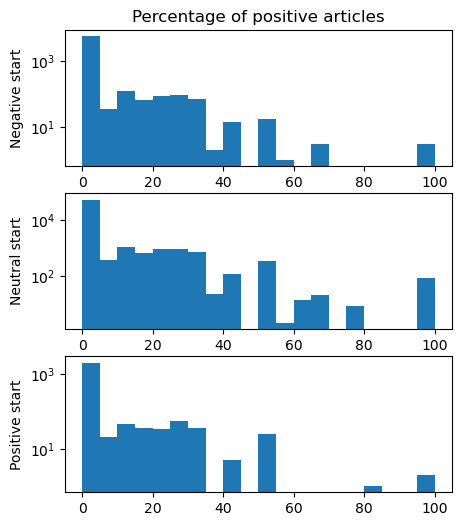

In [ ]:
def plot_comparaison(column,observed,bins_nbr=20):
    '''
    Plot the observed variable distributions
    :param column: variable to plot
    :param observed: the observed parameter in string (positive or negative)
    :param bins_nbr: number of bins for histogram plotting
    '''
    arrs=[]
    counts=[]

    arrs.append(df_paths[df_paths['Starting']==-1][column].values)
    arrs.append(df_paths[df_paths['Starting']==0][column].values)
    arrs.append(df_paths[df_paths['Starting']==1][column].values)

    fig,axs=plt.subplots(3,1,figsize=(5,6))

    for i in range(3):
        count,bins,_=axs[i].hist(100*arrs[i],bins=bins_nbr,range=(0,100))
        axs[i].set_yscale('log')
        counts.append(count)


    axs[0].set_ylabel('Negative start')
    axs[0].set_title('Percentage of '+observed+' articles')
    axs[1].set_ylabel('Neutral start')
    axs[2].set_ylabel('Positive start')

    return arrs,counts,bins

arrs_pos,counts,bins=plot_comparaison('Pos % 2','positive')

As expected, the distributions looks quite similar. To prove our hypothesis, some more rigorous statistic tests are required.
Before doing this, the same analysis is done for question B.

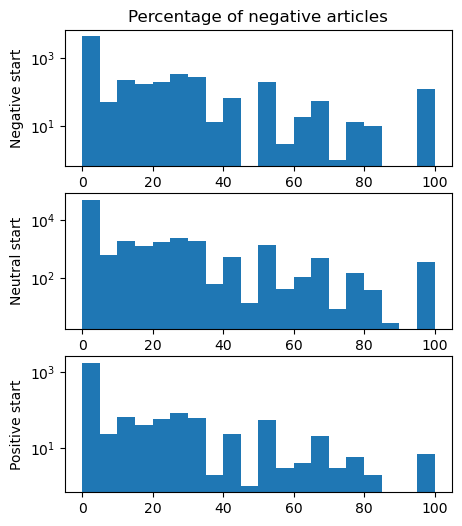

In [ ]:
df_paths.loc[df_paths['Starting']==-1,'Neg % 2']=round((df_paths['Neg Nbr']-1)/(df_paths['Length']-1),2)
df_paths.loc[df_paths['Starting']!=-1,'Neg % 2']=round((df_paths['Neg Nbr'])/(df_paths['Length']-1),2)

arrs_neg,counts,bins=plot_comparaison('Neg % 2','negative')

Same as for positive, the distributions look very similar.

### Statistical analysis

The null hypothesis is that the distributions are the same regardless of the starting article score, which is equivalent to saying that they are independant. This can be verified (or not) through a <b> Man-Whitney U</b>  test.

The first step is to calculate the distributions

In [ ]:
def calculate_distribution(arrs,bin_nbr=20):
    '''
    Calculate the count in each bin (which gives the distribution)
    :param arrs: list of array containing the value of the observed variable
    :param bin_nbr: number of bin for histogram distribution
    '''

    bin_length=1/bin_nbr
    col=np.round(bin_length*np.arange(bin_nbr),3)

    observed_values=pd.DataFrame(columns=col)

    for i in range(3):
        arr=arrs[i]

        for j in col:
            nbr=len(arr[(arr>=j) & (arr<(j+bin_length))])
            observed_values.loc[i,j]=nbr

        observed_values.loc[i,col[-1]]=observed_values.loc[i,col[-1]]+len(arr[arr==(1)])

    return observed_values

In [ ]:
distributions_pos=calculate_distribution(arrs_pos)
distributions_pos

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
0,5577,34,123,66,86,93,69,2,14,0,17,1,0,3,0,0,0,0,0,3
1,56597,362,1086,693,927,945,717,22,115,0,331,15,13,20,0,8,0,0,0,84
2,2025,20,46,35,34,55,36,0,5,0,25,0,0,0,0,0,1,0,0,2


In [ ]:
distributions_neg=calculate_distribution(arrs_neg)
distributions_neg

,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
0,4329,51,239,171,200,335,273,13,67,0,191,20,18,55,1,13,10,0,0,127
1,48975,614,1970,1299,1719,2327,1863,63,555,14,1331,149,109,500,9,155,41,3,0,353
2,1819,23,67,42,59,87,61,2,24,1,54,7,4,22,3,6,2,0,0,7


They are now normalized and compared two by two with the Man-Whitney U test

In [ ]:
def mannwhitneyu_test(distributions,alpha=0.05,method='exact'):
    '''
    Normalize the distributions and compare it with Man-Whithney U test
    :param distributions: distributions of observed variable
    :param alpha: significance level
    :param method: method used for the Man-Whithney U test
    '''

    normalized_distributions_pos=normalize(distributions)

    pairs=[]
    for i in range(len(normalized_distributions_pos)):
        for j in range(i+1,len(normalized_distributions_pos)):
            pair=tuple([normalized_distributions_pos[i],normalized_distributions_pos[j]])
            pairs.append(pair)

    print('The p values are:')
    i=0
    for pair in pairs:
        _,p=scp.mannwhitneyu(pair[0],pair[1],method=method)
        if p>alpha:
            i+=1
        else:
            print('The null hypothesis is rejected')
        print(p)

    if i==3:
        print('\nThe null hypothesis is not rejected')

In [ ]:
mannwhitneyu_test(distributions_pos)

The p values are:
0.9893316331242529
0.9042080378734633
0.9893316331242529

The null hypothesis is not rejected


In [ ]:
mannwhitneyu_test(distributions_neg)

The p values are:
0.6783062034017201
0.9680023952887521
0.9466954688892107

The null hypothesis is not rejected


As we can see on both results, all the p values are very high, and therefore the distributions can be assumed to be independant.  
Therefore, <b>the starting article does not influence either the positivity or the negativity of the path.</b>

# Question 2  
Can we observe any consistent emotional arcs in the paths?

### Imports

In [ ]:
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Analyzing Emotional Arcs in Paths

This notebook aims to analyze emotional arcs in a dataset of paths. Each path consists of a series of sentiment scores representing emotional states over a Wikispeedia path. We categorize each path into one of five categories: positive to negative, negative to positive, positive to positive, negative to negative and mixed emotions.


In [ ]:
def analyze_emotional_arcs(data, threshold=0):
    """
    Analyze emotional arcs in the given dataset with a threshold to determine sentiment.
    
    Parameters:
    data (list of lists): Each sublist represents a path with sentiment scores.
    threshold (float): The value used to determine the sentiment threshold.
    
    Returns:
    dict: A dictionary with analysis results, including common patterns in emotional arcs.
    """
    analysis_results = {
        'positive_to_negative': 0,
        'negative_to_positive': 0,
        'positive_to_positive': 0,
        'negative_to_negative': 0,
        'mixed_emotions': 0
    }
    
    for path in data:
        if len(path) < 3:
            analysis_results['mixed_emotions'] += 1
            continue

        third = len(path) // 3
        start_third_avg = sum(path[:third]) / third
        middle_third_avg = sum(path[third:-third]) / (len(path) - 2 * third) if len(path) - 2 * third > 0 else 0
        end_third_avg = sum(path[-third:]) / third
        
        if start_third_avg > threshold and end_third_avg < -threshold:
            analysis_results['positive_to_negative'] += 1
        elif start_third_avg < -threshold and end_third_avg > threshold:
            analysis_results['negative_to_positive'] += 1     
        elif start_third_avg > threshold and end_third_avg > threshold:
            analysis_results['positive_to_positive'] += 1
        elif start_third_avg < -threshold and end_third_avg < -threshold:
            analysis_results['negative_to_negative'] += 1
        else:
            analysis_results['mixed_emotions'] += 1

    return analysis_results


After defining the function, all the necessary data have to be imported in the notebook.

In [ ]:
with open('df_paths_direct.pickle', 'rb') as file:
    df_paths = pickle.load(file)
    
df_paths = df_paths[pd.isna(df_paths['Target score'])] # For this analysis we consider only the succesful paths
df_paths.head()

,Scores,Rounded,Target score
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN


Upon defining the function and importing the patterns, the initial step in our analysis should involve quantifying the diversity of prevalent trends observed.

positive_to_negative: 25.4141%
negative_to_positive: 21.1544%
positive_to_positive: 12.9000%
negative_to_negative: 38.9123%
mixed_emotions: 1.6193%


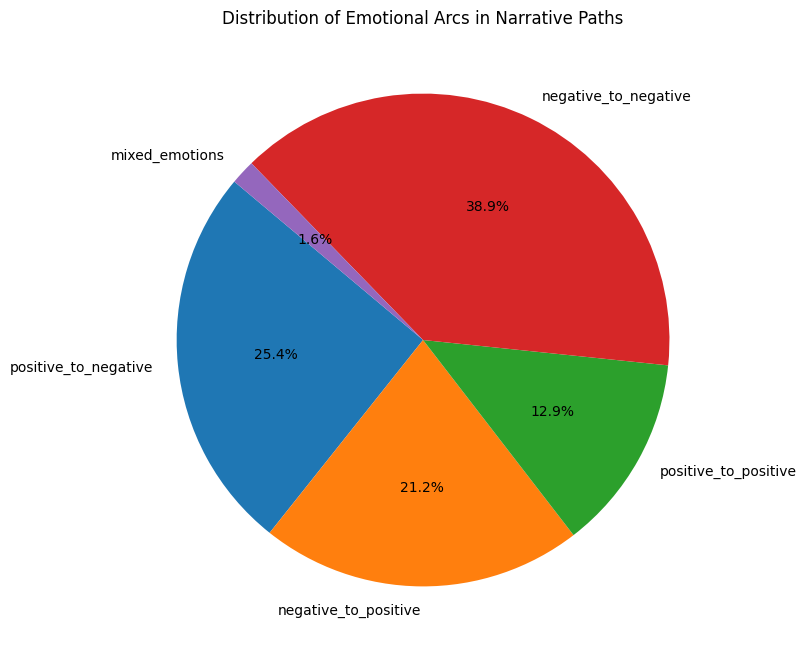

In [ ]:
emotional_arcs_analysis = analyze_emotional_arcs(df_paths['Scores'])
total_paths = sum(emotional_arcs_analysis.values())
emotional_arcs_proportions = {arc: count / total_paths for arc, count in emotional_arcs_analysis.items()}
categories = []
percentages = []
for arc, proportion in emotional_arcs_proportions.items():
    categories.append(arc)
    percentages.append(proportion*100)
    print(f"{arc}: {proportion*100:.4f}%")

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotional Arcs in Narrative Paths')
plt.show()

- Only 1.6% of paths exhibits mixed emotions, indicating a complex emotional journey rather than an easily identifiable path.
- A fairly large number of paths show a transition from positive to negative emotions, while the opposite appear to be slightly less frequent. 
- U-shaped emotional arcs oscillating from positive to positive are far more uncommon than negative to negative, and represent respectively the smallest (besides mixed emotions) and biggest trends.

To address concerns about the binary classification of paths as purely positive or negative based on their average score, we can refine our approach by introducing a threshold for neutral paths. Specifically, paths with scores ranging between -0.1 and 0.1 would be classified as neutral. This adjustment offers a more nuanced and realistic representation of the data, acknowledging paths that don't strongly lean towards either extreme of sentiment, but most offen show neutral values.

positive_to_negative: 3.2016%
negative_to_positive: 2.8606%
positive_to_positive: 1.4634%
negative_to_negative: 7.2840%
mixed_emotions: 85.1904%


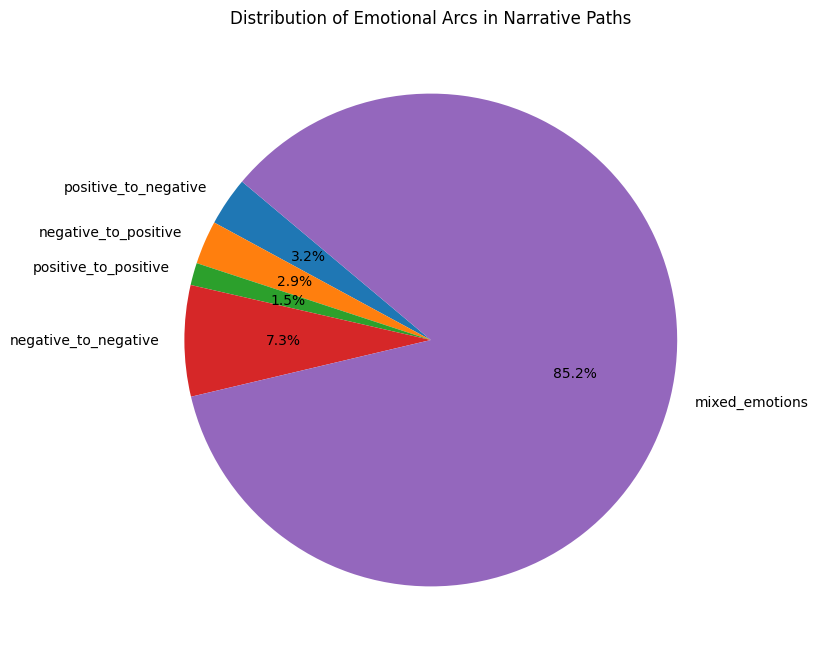

In [ ]:
emotional_arcs_analysis = analyze_emotional_arcs(df_paths['Scores'], threshold=0.1)
total_paths = sum(emotional_arcs_analysis.values())
emotional_arcs_proportions = {arc: count / total_paths for arc, count in emotional_arcs_analysis.items()}
categories = []
percentages = []
for arc, proportion in emotional_arcs_proportions.items():
    categories.append(arc)
    percentages.append(proportion*100)
    print(f"{arc}: {proportion*100:.4f}%")

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotional Arcs in Narrative Paths')
plt.show()

After applying the threshold, we observed that the overall trend remains consistent, yet there's a significant increase in the paths classified as mixed emotions. 

This observation suggests that our current analysis, highly sensitive to the chosen threshold value, might not be the most effective for studying pattern trends. It indicates the need for more robust statistical methods to accurately discern and analyze trends in the data. 

## Clustering

To facilitate the analysis of the patterns, it's advantageous to split them into three distinct and easily identifiable values, that is, the mean value of the beginning, the middle and the end of the paths. This categorization simplifies the means to perform further comparison and enhances the interpretability of results.

In [ ]:
def split_list(lst):
    n = len(lst)
    size = n // 3
    remainder = n % 3
    indices = [0 + size * i + min(i, remainder) for i in range(4)]
    return [lst[indices[i]:indices[i + 1]] for i in range(3)]

# Divide the paths into three parts and remove the ones with length inferior to 3
df_paths['Split_Scores'] = df_paths['Scores'].apply(lambda x: split_list(x) if len(x) >= 3 else np.NaN)
data = df_paths['Split_Scores'].dropna().to_list()

In [ ]:
mean_list = []
for i, sublist in enumerate(data):
    new_list = []
    for list in sublist:
        mean = np.mean(list)
        new_list.append(mean)
    mean_list.append(new_list)
    if i <= 5:
        print(new_list) # Print the first 5 lists to show the intermediate result

[-0.05701372331580512, 0.02285048508252055, -0.5790338682112557]
[-0.09784516017212513, -0.4750232424984818, -0.7870551196368035]
[-0.3156218438435746, -0.35942066050603594, -0.818829315600258]
[-0.05487595883307892, -0.05476150467499277, 0.0806443166846585]
[-0.05895270712643638, -0.49519910992416655, -0.03754376001933862]
[-0.09784516017212513, -0.0016815061165783643, -0.03754376001933862]


To enhance our comprehension of the prevalent trends in Wikispeedia patterns, performing clustering can be a good idea. This technique excels in neatly segmenting complex data into distinct groups based on similarities, thereby spotlighting the most common behavioral patterns.

In [ ]:
warnings.filterwarnings("ignore") # Ignore warnings it the code below to improve readability

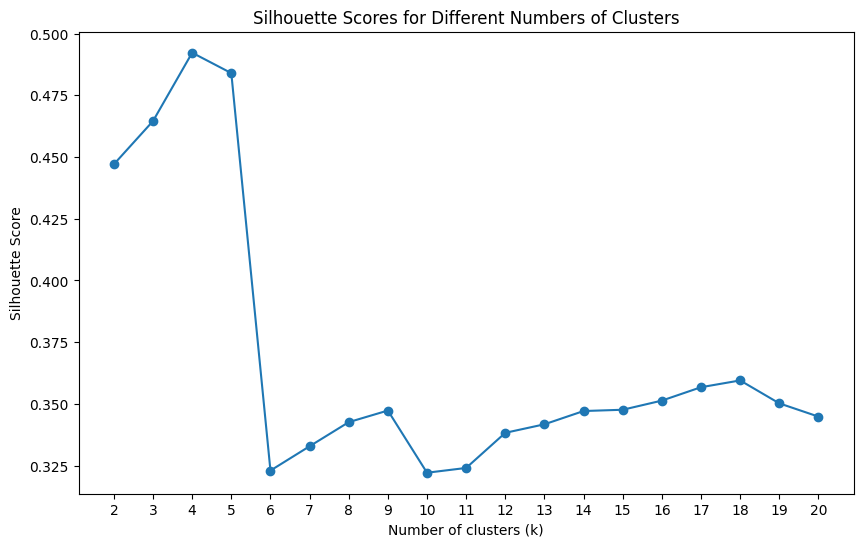

In [ ]:
features = np.array([[lst[i+1] - lst[i] for i in range(len(lst)-1)] for lst in mean_list])

k_range = range(2, 21) 

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    score = silhouette_score(features, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(k_range)
plt.show()

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

k = silhouette_scores.index(max(silhouette_scores)) + 2 # Get the number of clusters with the highest silhouette score
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(features_normalized)


The silhouette score analysis of the data conclusively indicates that four clusters are sufficient to encapsulate the key variations in path trends, providing a clear and efficient segmentation for understanding the essential differences.

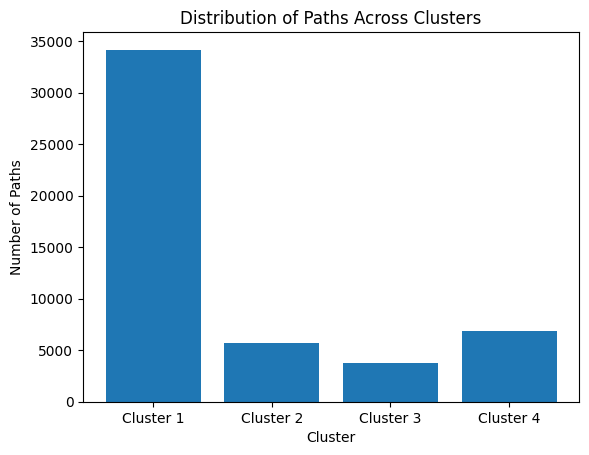

In [ ]:
frequencies = []
for i in range(k):
    count = 0
    for j, lst in enumerate(data):
        if clusters[j] == i:
            count += 1
    frequencies.append(count)

cluster_labels = [f'Cluster {i+1}' for i in range(k)]
plt.bar(cluster_labels, frequencies)
plt.xlabel('Cluster')
plt.ylabel('Number of Paths')
plt.title('Distribution of Paths Across Clusters')
plt.show()
            

A pie chart can provide a more visually intuitive and immediate understanding of the data.

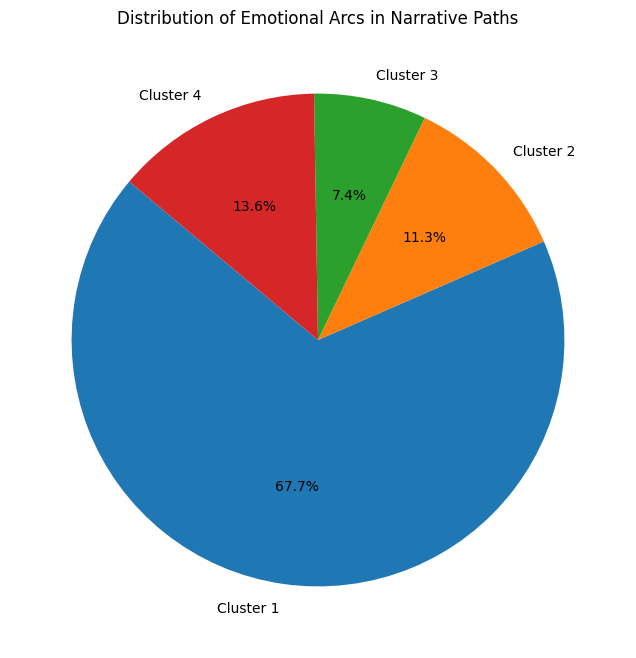

In [ ]:
percentages = [frequency / len(data) * 100 for frequency in frequencies]
cluster_labels = [f'Cluster {i+1}' for i in range(k)]
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=cluster_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotional Arcs in Narrative Paths')
plt.show()
           

In the first cluster, the vast majority of the paths are grouped, indicating that this cluster represents the most dominant pattern in the dataset. The second and fourth clusters contain a considerable but notably smaller number of paths compared to the first, suggesting that while these patterns are significant, they are less prevalent, while the third cluster shows to contain the fewest paths.

In [ ]:
mean_clusters = []
for i in range(k):
    new_list = []
    for j, lst in enumerate(data):
        if clusters[j] == i:
            new_list.append([sum(sublist) / len(sublist) for sublist in lst])
    cluster_mean = [sum(values) / len(new_list) for values in zip(*new_list)]
    mean_clusters.append(cluster_mean)
mean_clusters

[[-0.016579378921010173, -0.03267919486477002, -0.03359431423265522],
 [0.0319312770988049, -0.3851217319980016, -0.008419282199169627],
 [-0.3402031043316248, 0.08283902570681093, 0.01449662379523455],
 [-0.03159900878821033, -0.06693447716031418, -0.6664092053147421]]

In order to effectively visualize and understand the trends represented by these clusters, a graphical representation of the average values of these clusters is indeed more suited.

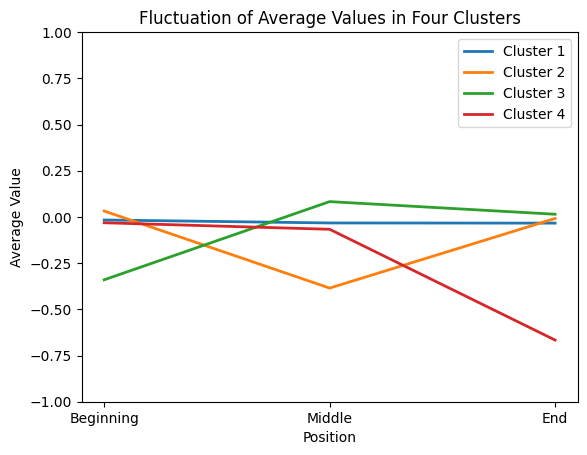

In [ ]:
for i, cluster in enumerate(mean_clusters):
    plt.plot(['Beginning', 'Middle', 'End'], cluster, label=f'Cluster {i+1}', linewidth=2.0)

plt.xlabel('Position')
plt.ylabel('Average Value')
plt.title('Fluctuation of Average Values in Four Clusters')
plt.ylim(-1, 1)
plt.legend()
plt.show()

This plot illustrates the predominant trends identified in our pattern analysis. The first cluster, representing the most common trend, follows a consistent trajectory with a near-zero value, aligning with our expectations of a stable, neutral sentiment. The second trend showcases a U-shaped pattern, beginning and ending with neutral sentiment but dipping into negative territory in the middle. This suggests a tendency for neutral articles to briefly adopt a more negative tone before returning to neutrality. The third and fourth clusters, though less common, exhibit distinct characteristics: the third starts negatively before transitioning to neutrality, while the fourth does the opposite, ending on a particularly negative note after a neutral start. This may suggest that neither negative nor positive scores are consistently found throughout the whole length of the path, but instead they are usually singular outliers or few neighbors. 

The noticeable absence of positive sentiment peaks across all clusters indicates that the algorithm employed for sentiment analysis tends to identify more negative sentiments. This bias towards negativity could likely be attributed to the structural and stylistic elements of Wikipedia articles. Such articles, often factual and objective in nature, may inherently contain language that the algorithm interprets more easily as negative rather than positive. 

Our analysis revealed an intriguing trend: articles at the end of the paths tend to have lower sentiment scores. This pattern could be attributed to a strategic approach by users when navigating towards a negatively perceived final article. For instance, if a user aims to reach an article like 'Adolf Hitler', he is more likely to traverse through similarly negative subjects such as 'World War Two' or 'Holocaust' near the end of their journey. These subjects, often closely linked in context, form a logical progression towards the intended negative outcome, and can therefore explain why negative articles are more likely to cluster at the end of the path. Conversely, we observed that negatively perceived topics tend not to cluster at the beginning or middle of a search. For instance, in a user's quest to find 'Mercedes Benz', an article like 'Adolf Hitler' might be selected in anticipation of its connection to 'Germany,' but this doesn't typically initiate a sequence of negative articles, suggesting that while negative topics might serve as stepping stones due to their contextual links, they don't usually set the overall tone of the search journey. This observation highlights a nuanced aspect of user navigation behavior, particularly in how sentiment perceptions influence the structuring of their search paths.


In [ ]:
negative_end = cluster[2]
size_cluster = 0
count = 0
for j, lst in enumerate(data):
    if clusters[j] == 2:
        size_cluster += 1
        if lst[-1][-1] < -0.5:
            count += 1

print(f'Percentage of path with negative goal article in cluster 3: {count/size_cluster*100:.2f}%')

Percentage of path with negative goal article in cluster 3: 83.27%


To validate our hypothesis, we quantitatively assessed the paths in the fourth cluster, focusing on those with a negatively perceived end goal (defined as articles with a sentiment score below -0.5). The resulting statistic is striking: 83.27% of the paths in this cluster indeed had a negative target article. This significant majority reinforces our hypothesis, confirming that most narratives within this cluster are directed towards a negative endpoint., explaining also why the average sentiment scores are lower in this cluster compared to the other three.  

# Question 3
Are there noticeable patterns of sentiment oscillation in the paths chosen by players? For instance, do players often navigate through contrasting sentiments to reach their target, such as starting from an article with a negative tone like “Hell” to reach a positive one like “Paradise”?

### Imports

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display, HTML

### Loading data
Loading the paths and sentiment scores for each article.  
Assumptions:
- The graph is undirected, because the user can always return back to the previous article via the back button.
- User paths can have circle, the back button in path is equivalent as the previous previous article.
- The sentiment score is generated by Roberta model and it's a 3 dimensional(positive neutral negative) vector, the sum of the 3 dimensions is 1.

In [ ]:
def replace_lt_with_previous(article_path):
    path_elements = article_path.split(';')
    for i, element in enumerate(path_elements):
        if element == '<' and i > 1:
            path_elements[i] = path_elements[i-2]
    return ';'.join(path_elements)

In [ ]:
file_path = '../data/paths_finished.tsv'
df_finished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
df_finished.columns = cols
df_finished['target'] = df_finished['path'].apply(lambda x: x.split(';')[-1])
df_finished['type'] = 'finished'
file_path = '../data/paths_unfinished.tsv'
df_unfinished = pd.read_csv(file_path, sep='\t', header=None)
cols = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
df_unfinished.columns = cols
df = pd.concat([df_finished, df_unfinished], axis=0)
df['start'] = df['path'].apply(lambda x: x.split(';')[0])
df['path_length'] = df['path'].apply(lambda x: len(x.split(';')))
df['path'] = df['path'].apply(replace_lt_with_previous)
# dump to csv
df[['durationInSec', 'path', 'target', 'type', 'start', 'path_length']].to_csv('../data/paths.tsv', sep='\t', index=False)

In [ ]:
articles = pd.read_csv('../data/articles.tsv', sep='\t', header=None)
file_path = '../data/links.tsv'
df_links = pd.read_csv(file_path, sep='\t', header=None)
articles.columns = ['article']
degree_out = df_links.groupby(0).count().reset_index()
degree_out.columns = ['article', 'degree_out']
degree_in = df_links.groupby(1).count().reset_index()
degree_in.columns = ['article', 'degree_in']
articles = articles.merge(degree_out, on='article', how='left').fillna(0).merge(degree_in, on='article', how='left').fillna(0)
articles['degree'] = articles['degree_out'] + articles['degree_in']
article_freq = pd.DataFrame(df['path'].apply(lambda x: x.split(';')).explode().value_counts()).reset_index()
articles_cnt = pd.merge( articles, article_freq, left_on='article', right_on='path', how='left').fillna(0)
articles_cnt.head()

,article,degree_out,degree_in,degree,path,count
0,# The list of all articles.,0.0,0.0,0.0,0,0.0
1,"# Article names are URL-encoded; e.g., in Java...",0.0,0.0,0.0,0,0.0
2,# FORMAT: article,0.0,0.0,0.0,0,0.0
3,#,0.0,0.0,0.0,0,0.0
4,"# When publishing on this data set, please cite:",0.0,0.0,0.0,0,0.0


In [ ]:
with open('tmp/sentiments.pickle', 'rb') as handle:
    sentiments = pickle.load(handle)

articles_cnt['sentiment_pos'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][2] if x+".txt" in sentiments else 0)
articles_cnt['sentiment_neu'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][1] if x+".txt" in sentiments else 0)
articles_cnt['sentiment_neg'] = articles_cnt['article'].apply(lambda x: sentiments[x+".txt"][0] if x+".txt" in sentiments else 0)
articles_cnt[['article','degree','sentiment_pos', 'sentiment_neu', 'sentiment_neg']].to_csv('../data/articles_sentiments.tsv', sep='\t', index=False)
articles_cnt
# output the df to csv
# articles_cnt.to_csv('../data/articles.tsv', sep='\t', index=False)

,article,degree_out,degree_in,degree,path,count,sentiment_pos,sentiment_neu,sentiment_neg
0,# The list of all articles.,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
1,"# Article names are URL-encoded; e.g., in Java...",0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
2,# FORMAT: article,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
3,#,0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
4,"# When publishing on this data set, please cite:",0.0,0.0,0.0,0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
4610,Zionism,74.0,25.0,99.0,Zionism,28.0,0.072466,0.663531,0.264004
4611,Zirconium,42.0,15.0,57.0,Zirconium,34.0,0.097269,0.781787,0.120944
4612,Zoroaster,28.0,9.0,37.0,Zoroaster,22.0,0.084953,0.786462,0.128585
4613,Zuid-Gelders,5.0,5.0,10.0,Zuid-Gelders,10.0,0.069110,0.797628,0.133262


### Sentiment visualization
It gives visualizations of the sentiment scores of the articles in the graph. and conduct some first glance observations.

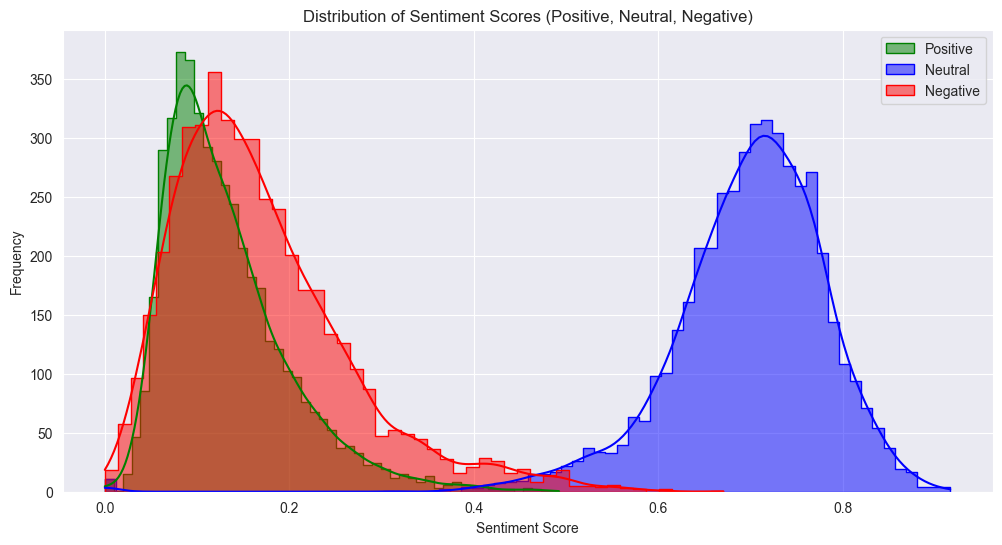

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=articles_cnt, x="sentiment_pos", color="green", label="Positive", kde=True, element="step")
sns.histplot(data=articles_cnt, x="sentiment_neu", color="blue", label="Neutral", kde=True, element="step")
sns.histplot(data=articles_cnt, x="sentiment_neg", color="red", label="Negative", kde=True, element="step")
plt.title("Distribution of Sentiment Scores (Positive, Neutral, Negative)")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Firstly visualize the 3 type score saparately, we can see that the majority of the scores tend to be neutral, with fewer instances of strong positive or negative sentiments.

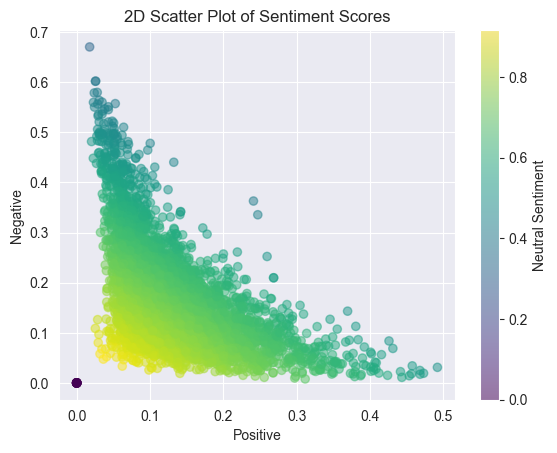

neutral article percentage: 


,article,degree_out,degree_in,degree,path,count,sentiment_pos,sentiment_neu,sentiment_neg
2158,Iraq_War,57.0,22.0,79.0,Iraq_War,77.0,0.024308,0.425385,0.550307


In [ ]:
plt.scatter(articles_cnt['sentiment_pos'], articles_cnt['sentiment_neg'], c=articles_cnt['sentiment_neu'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Neutral Sentiment')
plt.title("2D Scatter Plot of Sentiment Scores")
plt.xlabel("Positive")
plt.ylabel("Negative")
plt.grid(True)
plt.show()
print("neutral article percentage: ")
articles_cnt[(articles_cnt['sentiment_pos'] < 0.3) & (articles_cnt['sentiment_neg'] < 0.3)].shape[0] / articles_cnt.shape[0]
articles_cnt[articles_cnt['article'] == 'Iraq_War']

then we draw the distribution per article, neutral sentiment is article still the majority.(>88%)

### Edge Oscillation analysis
This block will analyze the sentiment oscillation pattern for edges in the network, it will be used to define the threshold of "oscillation" for the edges.
- sum of the absolute difference of the positive/negative sentiment scores between two articles in the edge is used to define the oscillation.
- the threshold is defined as the 90% quantile of the oscillation score.

In [ ]:
link_sentiments = df_links.merge(articles_cnt[['article', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']], left_on=0, right_on='article', how='left').drop(columns=['article']).merge(articles_cnt[['article', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']], left_on=1, right_on='article', how='left',suffixes=('_0', '_1')).drop(columns=['article'])
link_sentiments["oscillation"] = abs(link_sentiments['sentiment_pos_0'] - link_sentiments['sentiment_pos_1']) + abs(link_sentiments['sentiment_neg_0'] - link_sentiments['sentiment_neg_1'])

threshold_oscillation = link_sentiments['oscillation'].quantile(0.9)
print("threshold of oscillation: ", threshold_oscillation)
# save the link_sentiments to csv
# link_sentiments.to_csv('../data/link_sentiments.tsv', sep='\t', index=False)

threshold of oscillation:  0.2802105601443185


We get the threshold of oscillation as **0.28**, random select 10 links with oscillation score higher than the threshold, and 10 links lower to see if the threshold is reasonable.

In [ ]:
link_sentiments[link_sentiments['oscillation'] > 0.28].sample(10)

,0,1,sentiment_pos_0,sentiment_neu_0,sentiment_neg_0,sentiment_pos_1,sentiment_neu_1,sentiment_neg_1,oscillation
53226,Hurricane_Ivan,Atlantis,0.049873,0.521708,0.428419,0.089200,0.754380,0.156419,0.311327
34883,El_Salvador,Music_of_Spain,0.121037,0.597170,0.281793,0.250654,0.725191,0.024155,0.387254
115259,War,Anthropology,0.049537,0.518582,0.431880,0.102440,0.723685,0.173875,0.310907
38343,Fair_Isle,Shetland,0.401200,0.567084,0.031716,0.099732,0.808973,0.091295,0.361047
75694,Multiple_sclerosis,Canada,0.072813,0.520251,0.406936,0.208978,0.699237,0.091784,0.451318
13177,Battle_of_Alesia,Egypt,0.054259,0.599624,0.346117,0.151306,0.693953,0.154741,0.288423
52919,Humphry_Davy,Iodine,0.164724,0.763876,0.071399,0.058243,0.637897,0.303860,0.338943
86921,Polish%E2%80%93Muscovite_War_%281605%E2%80%931...,Opera,0.058507,0.651742,0.289751,0.214400,0.733925,0.051676,0.393969
78313,New_York_City,September_11%2C_2001_attacks,0.266598,0.656196,0.077206,0.034736,0.468619,0.496645,0.651302
108388,Tiktaalik,Crocodile,0.249895,0.719472,0.030633,0.113629,0.689188,0.197183,0.302817


In [ ]:
link_sentiments[link_sentiments['oscillation'] < 0.28].sample(10)

,0,1,sentiment_pos_0,sentiment_neu_0,sentiment_neg_0,sentiment_pos_1,sentiment_neu_1,sentiment_neg_1,oscillation
96872,Seaborgium,Bohrium,0.077101,0.845352,0.077546,0.060259,0.852763,0.086978,0.026274
99340,Smallpox,Roman_Empire,0.048696,0.523968,0.427336,0.065348,0.678970,0.255682,0.188307
119517,Zheng_He,Guangzhou,0.060579,0.775019,0.164402,0.117587,0.825559,0.056854,0.164556
92913,Roman_Empire,Africa,0.065348,0.678970,0.255682,0.091729,0.717100,0.191172,0.090891
96979,Seattle%2C_Washington,Mount_Rainier,0.244570,0.672309,0.083120,0.180217,0.716485,0.103298,0.084532
13251,Battle_of_Britain,Nazi_Germany,0.063146,0.501565,0.435289,0.059837,0.617856,0.322308,0.116290
41695,Funchal,Atlantic_Ocean,0.164147,0.791195,0.044659,0.102551,0.733198,0.164251,0.181187
84672,Persian_Empire,Royal_Navy,0.058836,0.780697,0.160466,0.100179,0.718883,0.180938,0.061814
63452,Lesotho,European_Union,0.077545,0.692120,0.230335,0.106352,0.740249,0.153400,0.105741
66258,List_of_rivers_by_length,Volga_River,0.041066,0.776305,0.182629,0.080152,0.849134,0.070714,0.151000


Following is the analysis of 2 main concerns:
1. does the user tend to make a move that has obvious sentiment change?
2. does the user tend to cause more/less oscillation compared to the network average level?

In [ ]:
link_sentiments['link'] = df_links[0] + ';' + df_links[1]
path_index = []
links = []
for index, row in df.iterrows():
    path = row['path'].split(';')
    for i in range(len(path)-1):
        link = path[i] + ';' + path[i+1]
        path_index.append(index)
        links.append(link)

In [ ]:
path_link = pd.DataFrame({'path_index': path_index, 'link': links})
path_link_sentiment = path_link.merge(link_sentiments, on='link', how='left')

Draw the distribution of the oscillation score of all links, and the threshold of oscillation. we can see the user tends to choose close sentiments between words.

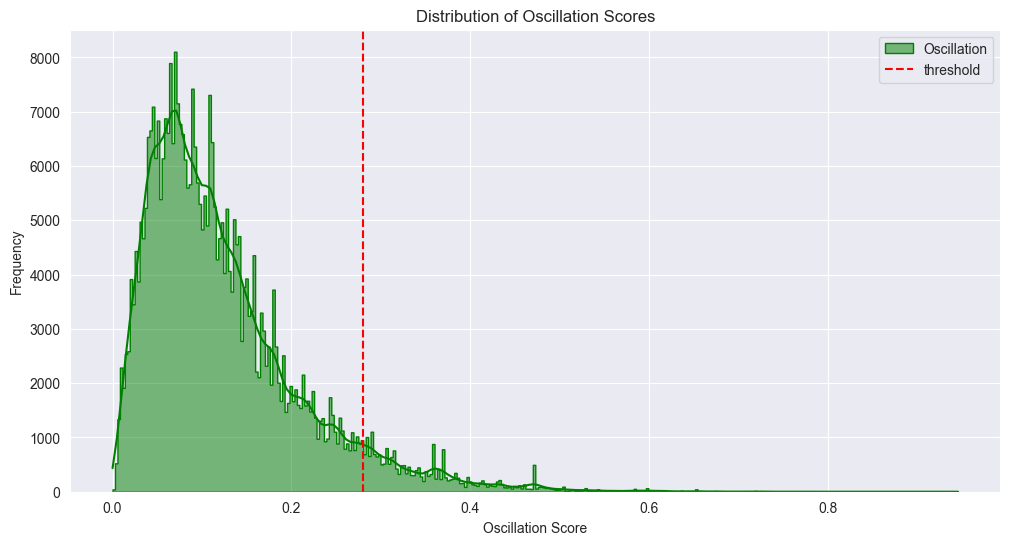

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=path_link_sentiment, x="oscillation", color="green", label="Oscillation", kde=True, element="step")
plt.axvline(x=threshold_oscillation, color='red', linestyle='--', label='threshold')
plt.title("Distribution of Oscillation Scores")
plt.xlabel("Oscillation Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Check which percentage of the links are above the threshold

In [ ]:
path_link_sentiment[path_link_sentiment['oscillation'] > threshold_oscillation].shape[0] / path_link_sentiment.shape[0]

0.062066119835950784

Users choose %94 of the links as oscillation links, while oscillation links only account for %90 if random choose.
Let's perform a random test to see if the threshold is reasonable.

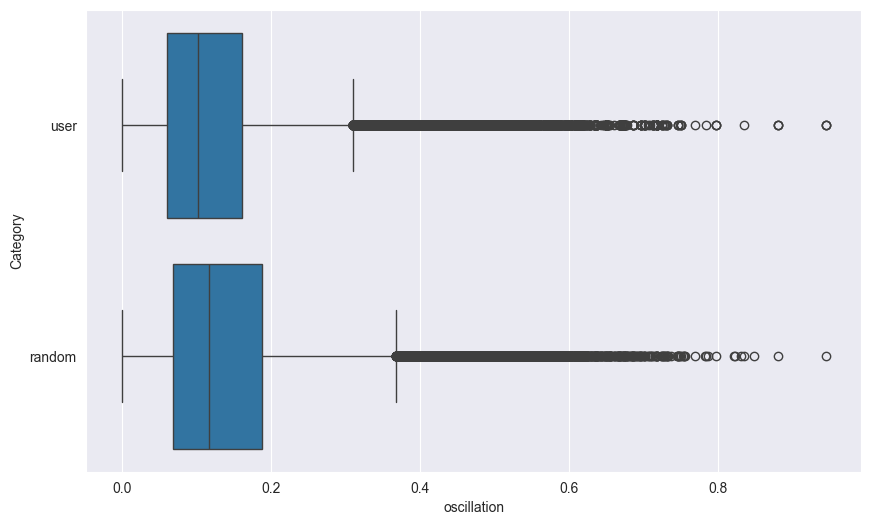

In [ ]:

d1 = path_link_sentiment['oscillation']
d2 = link_sentiments['oscillation']

df_box = pd.concat([d1.rename('oscillation'), d2.rename('oscillation')], axis=0, keys=['user', 'random'], names=['Category']).reset_index()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_box, x='oscillation', y='Category')
plt.show()

In [ ]:
from scipy import stats

t_stat, p_value = stats.ttest_ind(link_sentiments['oscillation'],path_link_sentiment['oscillation'].dropna(), equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 55.93270338503617
p-value: 0.0


Users dont tend to choose a more/less oscillated path

### Path oscillation analysis
This block will try to find factors that are correlated with the oscillation of a path, we mainly focus on the sentiment of start and end articles.

In [ ]:
import pickle
# load pickled data
with open('./df_paths1.pickle', 'rb') as f:
    df = pickle.load(f)


In [ ]:
def std_differenced_series(l):
    if(len(l) < 2):
        return 0
    return np.std(np.diff(l))


df['src'] = df['Scores'].apply(lambda x: x[0])
df['dst'] = df['Scores'].apply(lambda x: x[-1])
df['hp'] = df['Scores'].apply(lambda x: np.percentile(x, 25))
df['mp'] = df['Scores'].apply(lambda x: np.percentile(x, 50))
df['lp'] = df['Scores'].apply(lambda x: np.percentile(x, 75))
df.loc[df['Target score'].notna(), 'dst'] = df.loc[df['Target score'].notna(), 'Target score']
df['oscillation'] = df['Scores'].apply(lambda x: std_differenced_series(x))
df['diff'] = np.abs(df['dst'] - df['src'])
df['length'] = df['Scores'].apply(lambda x: len(x))
df['mean'] = df['Scores'].apply(lambda x: np.mean(x))
# output the df to csv
# df.to_csv('../data/paths_sentiment.csv', index=False)
df['oscillation'].describe()

count    76164.000000
mean         0.192886
std          0.188506
min          0.000000
25%          0.058579
50%          0.115168
75%          0.324489
max          1.303670
Name: oscillation, dtype: float64

We use standard deviation of a differenced sentiment list as the oscillation score of a path. the distribution is visualized below.

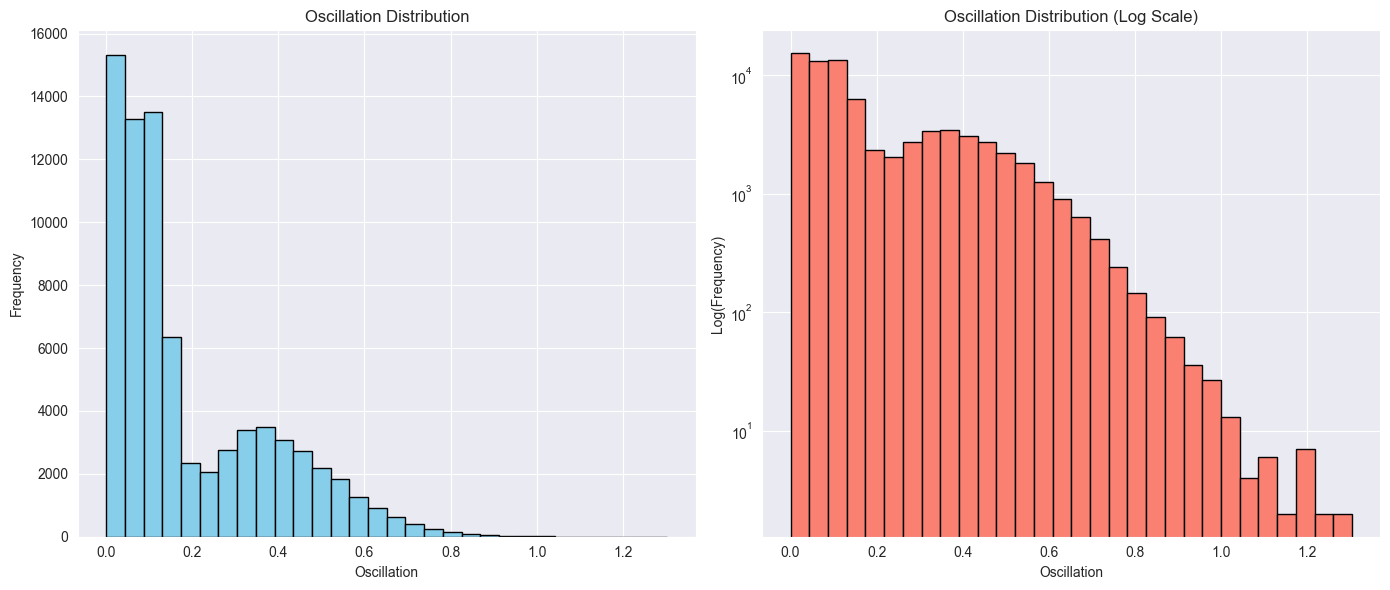

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.hist(df['oscillation'], bins=30, color='skyblue', edgecolor='black')
ax1.set_title('Oscillation Distribution')
ax1.set_xlabel('Oscillation')
ax1.set_ylabel('Frequency')
ax2.hist(df['oscillation'], bins=30, color='salmon', edgecolor='black', log=True)
ax2.set_title('Oscillation Distribution (Log Scale)')
ax2.set_xlabel('Oscillation')
ax2.set_ylabel('Log(Frequency)')
plt.tight_layout()
plt.show()

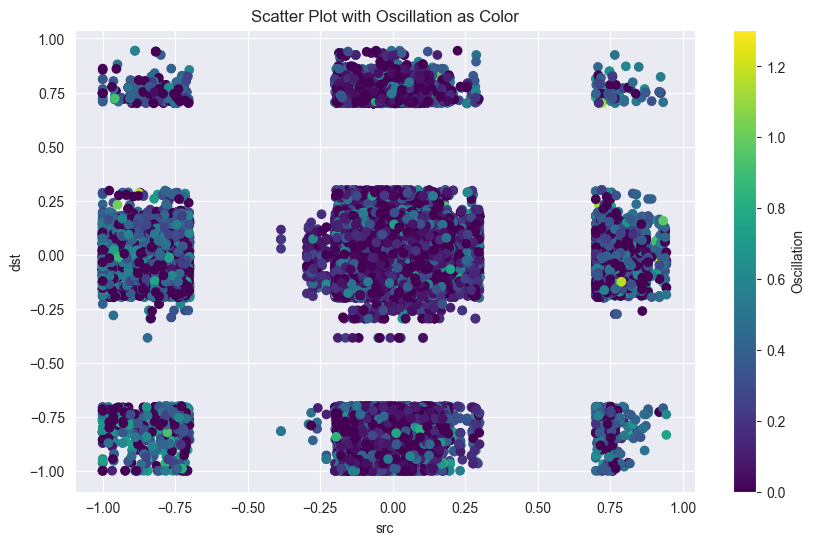

In [ ]:
norm = plt.Normalize(df['oscillation'].min(), df['oscillation'].max())
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['src'], df['dst'], c=df['oscillation'], cmap='viridis', norm=norm)
plt.colorbar(scatter, label='Oscillation')
plt.xlabel('src')
plt.ylabel('dst')
plt.title('Scatter Plot with Oscillation as Color')
plt.grid(True)
plt.show()

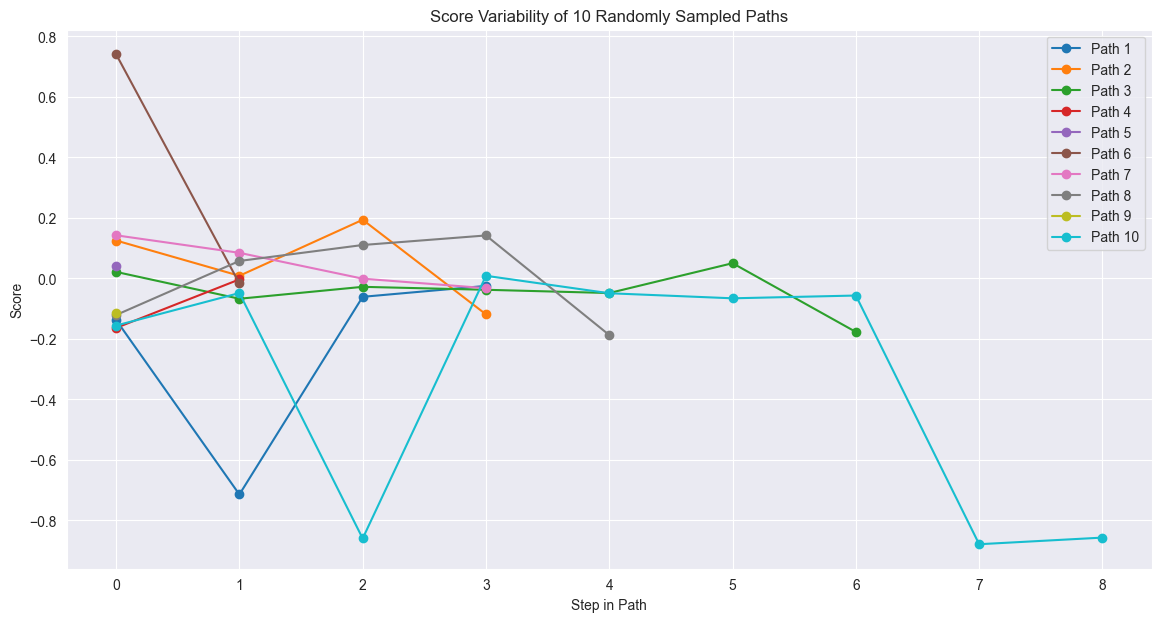

In [ ]:
sampled_paths_10 = df['Scores'].sample(10)
plt.figure(figsize=(14, 7))
colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]
for i, (scores, color) in enumerate(zip(sampled_paths_10, colors), start=1):
    plt.plot(scores, marker='o', label=f'Path {i}', color=color)

plt.title('Score Variability of 10 Randomly Sampled Paths')
plt.xlabel('Step in Path')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

It seems that the path will oscillate more when source and destination articles have more poralized sentiment, next we do regression analysis to see if this is true.

In [ ]:
model = smf.ols(formula='oscillation ~ src + dst', data=df)
results = model.fit()
display(HTML(results.summary().as_html()))

# cross validation prediction

R is very small, which means the oscillation is not correlated with the sentiment of source and destination articles, we consider 25,50, 75 percentile of the path and keep fitting.

In [ ]:
model2 = smf.ols(formula='oscillation ~ src + dst + hp + mp + lp', data=df)
results2 = model2.fit()
display(HTML(results2.summary().as_html()))

R is improved, then we consider some global attributes of the path(length/mean)

In [ ]:
model3 = smf.ols(formula='oscillation ~ src + dst + hp + mp + lp + length + mean', data=df)
results3 = model3.fit()
display(HTML(results3.summary().as_html()))

R increased to a acceptable level, we can see that the explain power is low if we only consider source and target, we can predict the oscillation better only if we know more about the path itself.

In [ ]:
correlation = df[['diff', 'oscillation']].corr().iloc[0, 1]
model4 = smf.ols(formula='oscillation ~ diff', data=df)
results4 = model4.fit()
print(f'Correlation between diff and oscillation: {correlation}')
# print only R squared value 
print(f'R squared value: {results4.rsquared}')

Correlation between diff and oscillation: 0.3224476643450003
R squared value: 0.10397249624154759


But the sentiment difference of source and target is correlated with the oscillation of the path, higher difference can lead to (%10 percentage)higher oscillation

# Question 4

In this section, we investigate the relationship between the target article sentiment and how it influences the path structure.
1. How does the sentiment score of a target topic affect the general <b><u>structure</u></b> of the path chosen by players? 
2. Is there a relationship between the extremity of a target article's sentiment (highly positive/negative) and the <b><u>length</u></b> of the path taken to reach it? We can decompose this in two causal questions. When players choose <b><u>shorter paths</u></b>, are these paths characterized by articles with, for example, more extreme sentiment scores? Conversely, do extreme-sentiment paths mean shorter paths?

### Imports

In [ ]:
from scipy.interpolate import interp1d
import statsmodels.formula.api as smf

### 1. Sentiment and Path Structure

In [ ]:
with open("df_paths1.pickle", "rb") as f:
    df = pickle.load(f)

Let's add some utility columns in the dataframe.

In [ ]:
df["Scores_mean"] = df["Scores"].apply(lambda x: sum(x)/len(x))
df["Path_length"] = df["Scores"].apply(lambda x: len(x))

In [ ]:
display(df)

,Scores,Rounded,Target score,Scores_mean,Path_length
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,-0.204399,9
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,-0.386558,5
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,-0.457848,8
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,-0.020967,4
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,-0.177478,7
...,...,...,...,...,...
76159,"[0.011778271523728776, -0.8782995301658347, -0...","[0, -1, 0, -1, -1, 0]",-0.826112,-0.409196,6
76160,[-0.18600953180292576],[0],0.282791,-0.186010,1
76161,"[0.7375556848610064, 0.0948245586412504, -0.05...","[1, 0, 0]",0.072405,0.258806,3
76162,"[-0.011092642140131198, 0.11030565085346924, -...","[0, 0, -1, -1]",-0.131333,-0.382254,4


Note: when ```Target score``` is NaN, it means that the target score is reached therefore the score can be found in the last element of the corresponding ```Scores``` list. When it is not reached, the score is specified in this ```Target score``` column.

For this first question, we want to visualize the paths. For this, we use a heatmap and interpolate the sentiments from adjacent paths to get a better sense of the structure of paths.

In [ ]:
max_path_length = 20
path_resolution = 20  # resolution between 2 articles; e.g. with 20: there are 20 points between source and 1st article clicked
score_resolution = 80 # 20 -> [-1, -0.9, ..., 0.9, 1]
score_step = (1-(-1))/score_resolution

def path_heatmap(df, title="Scores Heatmap", remove_target=False):
    """
    Heatmap method for visualizing paths of a pandas DataFrame. 
    Parameters for the function are defined above in the cell.
    Note that max_path_length can also be set to the maximum length of paths 
        in the DataFrame using df["Scores"].apply(len).max(), but in this case
        the max length is very big (~400) so by default the articles after max_path_length
        are aggregated in the farthest point of the heatmap (on the right of the plot).
    
    Input params:
        - df: (pandas.core.frame.DataFrame) dataframe with a 
            column Scores that contains lists of sentiment scores
        - title: (str) title for the heatmap
        - remove_target: (bool) remove the last element of each list of sentiments 
            for better visibility in the heatmap
        
    Output:
        - axis (matplotlib.image.AxesImage) of the plot of a heatmap of the sentiments, 
            interpolated between articles so that the fluctuations of sentiments are visualized
    """
    
    path_scores_heatmap = np.zeros((score_resolution, path_resolution*max_path_length))

    for i in df.index:
        path = df.loc[i]["Scores"][:-1] if remove_target else df.loc[i]["Scores"]
        
        # fix bug: some paths are Series, not list
        if type(path) != list:
            path = list(path)[0]
        x = np.arange(len(path))
        # print(x, type(x), len(path), path, type(path))
        f = interp1d(x,path)
        path_space = np.linspace(0,len(path)-1, path_resolution*len(path))
        f_path_space = f(path_space)
        for path_ind,score in enumerate(f_path_space):
            y_ind = round(score/score_step) + score_resolution//2
            path_scores_heatmap[y_ind, min(path_ind,path_resolution*max_path_length-1)] += 1

    # Plot the heatmap
    ax = plt.imshow(np.log(np.flipud(path_scores_heatmap)+1), aspect='auto', cmap='viridis', interpolation='nearest', extent=[0,12,-1,1])
    plt.colorbar()
    plt.xlabel('Path Index')
    plt.ylabel('Sentiment score $\in[-1,1]$')
    plt.title(title)
    plt.show()
    return ax

Let's visualize a random subset of the paths.

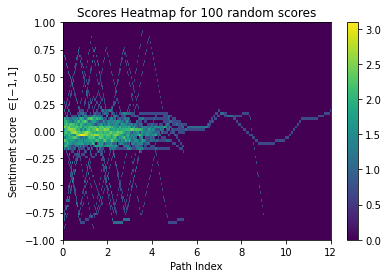

In [ ]:
size=100
rand_ind = np.random.choice(df.index, size=size)
path_heatmap(df[df["Path_length"] > 2].filter(items = rand_ind, axis=0), 
             title=f"Scores Heatmap for {size} random scores")
plt.show()

It is clear that most of the paths are centered in the neutral sentiment zone. This is due to the sentiment evaluation method that we chose (see above) which scores a large majority of the articles as neutral. Another thing we note is that most of the "high-sentiment" articles are negative. Indeed, again in the distribution of the article scores above, we saw that there were more negative articles than positive ones.

Now, let's dive into a causal analysis on whether or not the target sentiment affects the path structure. For now, we keep the "structure" feature purely a descriptive, non-formal one. 

But first, we notice that many of the paths have very short length, and we wonder whether these are of interest for our analysis. There are about 10,000 paths with length 1 or 2:

In [ ]:
len(df[(df["Path_length"] <= 2)])

10495

Out of these, only about 800 do actually reach their target (see cell below). Note that the paths that reach their target are the ones for which the column Target score is a NaN value as the target score is already present in the Scores column (since it is reached).

In [ ]:
len(df[(df["Path_length"] <= 2) & (df["Target score"].apply(lambda x: np.isnan(x)))])

831

We decide that short paths that do not reach their target are "rage-quits": they do not provide useful information for our analysis (they are noise). Similarly, short paths that reach their target are also noise: they are too easy! In both cases, neither does provide useful information, so we discard these in our following analyses. Now, let's focus on splitting the data according to the target's sentiment.

In [ ]:
df = df[df["Path_length"] > 2]

Let's gather the target articles' scores in a new column. Note that we differentiate the case where the target article was found or not. We then split the dataframe in 3 frames depending on the target score. 

In [ ]:
df["target_score_raw"] = df.apply(lambda x: x['Scores'][-1] if np.isnan(x['Target score']) else x['Target score'], axis=1)
df_positive = df[df["target_score_raw"] >= 0.5]
df_neutral = df[(df["target_score_raw"] > -0.5) & (df["target_score_raw"] < 0.5)]
df_negative = df[df["target_score_raw"] <= -0.5]

Note that the scores where we split the data seem arbitrary, but in fact the scores are very well split (we refer here again to the histogram of the articles' sentiment scores).

In [ ]:
df_positive.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,438.000000,2030.000000,2030.000000,2030.000000
mean,0.761764,0.098503,6.032020,0.758437
std,0.055430,0.141188,3.248302,0.050272
min,0.700043,-0.865857,3.000000,0.700043
25%,0.717978,0.010624,4.000000,0.716237
50%,0.747766,0.112524,5.000000,0.750177
75%,0.777580,0.182197,7.000000,0.782183
max,0.939431,0.626832,67.000000,0.943384


In [ ]:
df_negative.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,1316.000000,5960.000000,5960.000000,5960.000000
mean,-0.821085,-0.242910,5.866443,-0.816736
std,0.092857,0.170273,3.084960,0.087023
min,-1.000000,-0.942485,3.000000,-1.000000
25%,-0.879634,-0.353202,4.000000,-0.865036
50%,-0.790648,-0.225142,5.000000,-0.804227
75%,-0.740544,-0.136337,7.000000,-0.742560
max,-0.700808,0.440404,102.000000,-0.700045


In [ ]:
df_neutral.describe()

,Target score,Scores_mean,Path_length,target_score_raw
count,13428.000000,57679.000000,57679.000000,57679.000000
mean,-0.026903,-0.045076,6.010506,-0.029277
std,0.109761,0.111394,3.536139,0.103377
min,-0.385264,-0.878111,3.000000,-0.385264
25%,-0.122357,-0.083277,4.000000,-0.109475
50%,-0.038557,-0.033339,5.000000,-0.040235
75%,0.057017,0.010639,7.000000,0.042937
max,0.299472,0.627172,405.000000,0.299472


[Comment on ...]

Let us now visualize the paths using the heatmap tool. Note that the heatmap does not show the target sentiment, as this would add noise on the image (it would show more negativity when in reality it just represents the last click to the target).

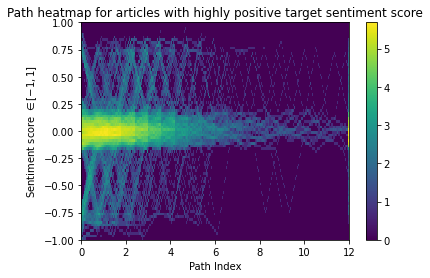

In [ ]:
path_heatmap(df_positive, 
             title="Path heatmap for articles with highly positive target sentiment score", 
             remove_target=True)
plt.show()

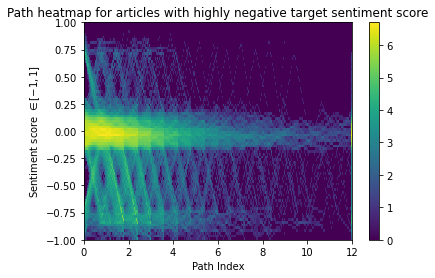

In [ ]:
path_heatmap(df_negative, 
             title="Path heatmap for articles with highly negative target sentiment score", 
             remove_target=True)
plt.show()

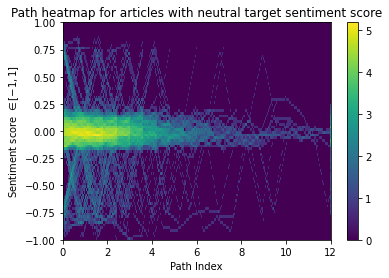

In [ ]:
path_heatmap(df_neutral.filter(items=np.random.choice(df_neutral.index, size=1000), axis=0), 
             title="Path heatmap for articles with neutral target sentiment score", 
             remove_target=True)
plt.show()

In the negative targets heatmap, it seems that there are much more negative articles along the path. However, surprisingly, in the positive targets heatmap, the paths are pretty balanced. One interesting thing to note is that the first few articles in the paths seems more negative, while in the later stages they seem more positive. Both these observations confirm the somewhat trivial statement: paths with positive targets tend to be more positive in the end of the paths, while paths with negative targets tend to get more negative in the end of the paths. Indeed, it seems logical that similar articles have similar sentiments (cf. subquestion 6), and that adjacent articles in the paths are of similar topics, therefore that sentiment scores before targets are similar to that of targets.

### 2. Target sentiment ~ path length ?

Let's try making a predictive model to determine the strength of the relationship between target sentiment and path length. Can a model predict the path length given the target sentiment?

In [ ]:
df["is_target_positive"] = df["target_score_raw"] > 0.5
df["is_target_negative"] = df["target_score_raw"] < -0.5

In [ ]:
df["is_target_positive"].sum(), df["is_target_negative"].sum()

(2030, 5960)

There are 2030 games with positive target, and 5960 games with negative targets.

In [ ]:
mod = smf.ols(formula='Path_length ~ C(is_target_positive) + C(is_target_negative)', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Path_length   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.704
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00906
Time:                        19:18:40   Log-Likelihood:            -1.7524e+05
No. Observations:               65669   AIC:                         3.505e+05
Df Residuals:                   65666   BIC:                         3.505e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.0105      0.015    413.736      0.000       5.982       6.039
C(is_target_positive)[T.True]     0.0215      0.079      0.273      0.785      -0.133       0.176
C(is_target_negative)[T.True]    -0.1441      0.047     -3.035      0.002      -0.237      -0.051
==============================================================================
Omnibus:                   166985.510   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      19940403342.826
Skew:                          27.681   Prob(JB):                         0.00
Kurtosis:                    2701.989   Cond. No.                         5.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The negativity of target seems to have some link towards predicting the path length. There is some negative correlation, and it is significant at the $0.05$ significance level because the p-value for the coefficient is $0.002$, indicating that we cannot reject the null hypothesis that there is no correlation between negativity of target sentiment and path length. Let us verify that the fact that a target is reached or not is a confounder variable in that case. 

In [ ]:
df["is_target_negative_and_reached"] = np.where((df["target_score_raw"] < -0.5) & np.isnan(df["Target score"]), 1, 0)
df["is_target_negative_and_not_reached"] = np.where((df["target_score_raw"] < -0.5) & (~ np.isnan(df["Target score"])), 1, 0)
df["is_target_positive_and_reached"] = np.where((df["target_score_raw"] > 0.5) & np.isnan(df["Target score"]), 1, 0)
df["is_target_positive_and_not_reached"] = np.where((df["target_score_raw"] > 0.5) & (~ np.isnan(df["Target score"])), 1, 0)
df.head()

,Scores,Rounded,Target score,Scores_mean,Path_length,target_score_raw,is_target_positive,is_target_negative,is_target_negative_and_reached,is_target_negative_and_not_reached,is_target_positive_and_reached,is_target_positive_and_not_reached
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN,-0.204399,9,-0.787055,False,True,1,0,0,0
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN,-0.386558,5,-0.787055,False,True,1,0,0,0
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN,-0.457848,8,-0.787055,False,True,1,0,0,0
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN,-0.020967,4,0.080644,False,False,0,0,0,0
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN,-0.177478,7,-0.051500,False,False,0,0,0,0


In [ ]:
mod = smf.ols(formula='Path_length ~ C(is_target_negative_and_reached) + \
                                     C(is_target_negative_and_not_reached) + \
                                     C(is_target_positive_and_reached) + \
                                     C(is_target_positive_and_not_reached)', data=df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Path_length   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.561
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00111
Time:                        19:18:41   Log-Likelihood:            -1.7523e+05
No. Observations:               65669   AIC:                         3.505e+05
Df Residuals:                   65664   BIC:                         3.505e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      6.0105      0.015    413.758      0.000       5.982       6.039
C(is_target_negative_and_reached)[T.1]        -0.1018      0.053     -1.913      0.056      -0.206       0.002
C(is_target_negative_and_not_reached)[T.1]    -0.2932      0.097     -3.014      0.003      -0.484      -0.103
C(is_target_positive_and_reached)[T.1]         0.1189      0.089      1.341      0.180      -0.055       0.293
C(is_target_positive_and_not_reached)[T.1]    -0.3324      0.167     -1.987      0.047      -0.660      -0.004
==============================================================================
Omnibus:                   167003.365   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      19951452208.502
Skew:                          27.688   Prob(JB):                         0.00
Kurtosis:                    2702.736   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

At the $0.05$ significance level, the coefficient for the articles with reached targets is <b>not</b> significant, while the coefficient for the articles with <b>un</b>reached targets is significant. We conclude that unreached targets lower the average game length... the fact that a game is finished was indeed a confounder. This conclusion is clearly trivial: when players give up, it shortens the path length. 

It would have been interesting to observe that, for instance, negative targets are more likely to make the player give up than positive targets. However, it does not seem to be the case. What does that tell us about human psychology online? When exploring the web, have we become completely insensible machines, completely unmindful of the information we are reading? In a competitive context where both time and strategy are competing inside one's thinking process, it seems that from our analyses we cannot reach a unified conclusion about the effect of the target article's sentiment.

# Question 5
Are certain categories or themes within Wikipedia consistently associated with similar sentiment scores? For example, do topics like fruits generally have a positive tone, while others might trend towards neutrality or negativity?

### Import Topic Information

In [ ]:
cat_df = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', sep='\t', skiprows=13, header=None)
cat_df.columns = ['article', 'category']
cat_df.category = cat_df.category.str.replace('_',' ')
cat_df[['category_lvl1', 'category_lvl2']] = cat_df['category'].str.split('.', expand=True)[[1,2]]
cat_df = cat_df.drop(columns=['category'])

cat_df

,article,category_lvl1,category_lvl2
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,History,British History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People,Historical figures
2,%C3%85land,Countries,None
3,%C3%85land,Geography,European Geography
4,%C3%89douard_Manet,People,Artists
...,...,...,...
5199,Zirconium,Science,Chemistry
5200,Zoroaster,People,Religious figures and leaders
5201,Zuid-Gelders,Geography,European Geography
5202,Zuid-Gelders,Language and literature,Languages


### Merge with sentiment scores

In [ ]:

with open('sentiments.pickle', 'rb') as file:
    sentiment_score = pickle.load(file)
articles_df = pd.DataFrame(sentiment_score).T.reset_index()
articles_df.columns = ['article', 'neg', 'neu', 'pos']
articles_df = articles_df.drop(columns=['neu'])

articles_df.article = articles_df.article.str[:-4]
articles_df

,article,neg,pos
0,Matter,0.235663,0.095422
1,Common_Tern,0.152064,0.097202
2,Restoration_literature,0.169710,0.132469
3,European_Kingfisher,0.076588,0.132150
4,Abuja,0.119582,0.208275
...,...,...,...
4599,Last_Supper,0.075478,0.158055
4600,Culture_of_the_Democratic_Republic_of_the_Congo,0.190738,0.089011
4601,Paleontology,0.041307,0.353286
4602,Achilles_tendon,0.251968,0.056279


In [ ]:
articles_df = articles_df.merge(cat_df,on='article', how='left')
articles_df

,article,neg,pos,category_lvl1,category_lvl2
0,Matter,0.235663,0.095422,Science,Physics
1,Common_Tern,0.152064,0.097202,Science,Biology
2,Restoration_literature,0.169710,0.132469,Language and literature,Literature types
3,European_Kingfisher,0.076588,0.132150,Science,Biology
4,Abuja,0.119582,0.208275,Geography,African Geography
...,...,...,...,...,...
5205,Last_Supper,0.075478,0.158055,Religion,Religious texts
5206,Culture_of_the_Democratic_Republic_of_the_Congo,0.190738,0.089011,Geography,African Geography
5207,Paleontology,0.041307,0.353286,Geography,General Geography
5208,Achilles_tendon,0.251968,0.056279,Science,Biology


### Evaluate on Most General Topics (Level 1)

In [ ]:
temp = articles_df.copy().groupby('category_lvl1')[['neg', 'pos']].mean().reset_index()
temp['sentiment'] = 0  # Default class is neutral (0)

# Assigning class labels based on conditions
temp.loc[temp['neg'] > temp['neg'].mean(), 'sentiment'] = -1  # Negative class
temp.loc[temp['pos'] > temp['pos'].mean(), 'sentiment'] = 1  # Positive class

temp

,category_lvl1,neg,pos,sentiment
0,Art,0.108214,0.156693,1
1,Business Studies,0.179589,0.139119,-1
2,Citizenship,0.219874,0.104897,-1
3,Countries,0.176955,0.128537,-1
4,Design and Technology,0.151030,0.143760,1
5,Everyday life,0.148628,0.165738,1
6,Geography,0.161224,0.132010,-1
7,History,0.221581,0.090100,-1
8,IT,0.145361,0.199694,1
9,Language and literature,0.169410,0.134165,-1


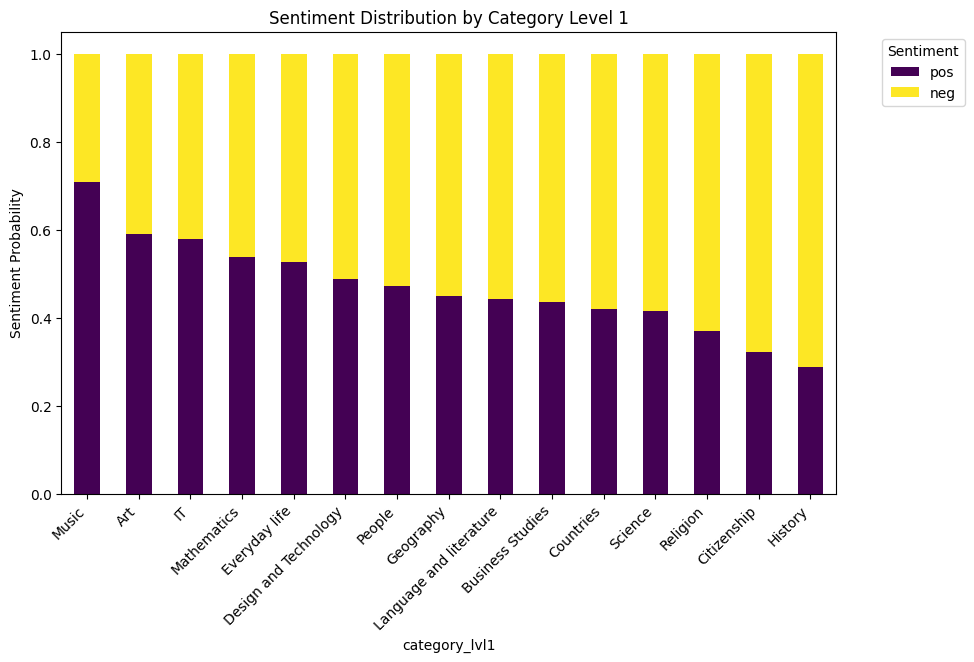

In [ ]:
temp = temp.drop(columns=['sentiment'])
temp[['neg', 'pos']] = temp[['neg', 'pos']].div(temp[['neg', 'pos']].sum(axis=1), axis=0)

temp = temp.sort_values(by='pos', ascending=False)

# Plotting
ax = temp.plot(kind='bar',x='category_lvl1',y=['pos', 'neg'], stacked=True, colormap='viridis', figsize=(10, 6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Sentiment Distribution by Category Level 1')
plt.ylabel('Sentiment Probability')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')



As can be seen, Music is seems to be more positive than the other topics. Let's take a closer look at the distribution of articles falling into this topic:

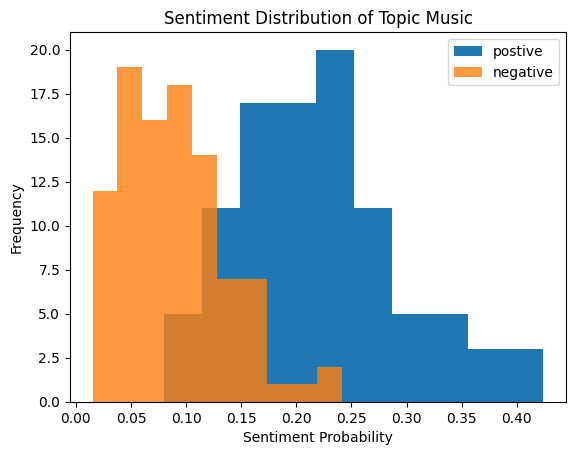

In [ ]:
plt.hist(articles_df[articles_df.category_lvl1 =='Music'].pos, label='postive')
plt.hist(articles_df[articles_df.category_lvl1 =='Music'].neg, label='negative', alpha=0.8)

plt.title('Sentiment Distribution of Topic Music')
plt.xlabel('Sentiment Probability')
plt.ylabel('Frequency')

plt.legend()

The positive sentiment distribution is higher than the negative sentiment distribution. 

### Evaluate on Level-2 Topics

In [ ]:
temp = articles_df.copy().groupby('category_lvl2')[['neg', 'pos']].mean().reset_index()
category_mapping = articles_df.set_index('category_lvl2')['category_lvl1'].to_dict()
temp['category_lvl1'] = temp.category_lvl2.map(category_mapping)
temp['sentiment'] = 0  # Default class is neutral (0)

# Assigning class labels based on conditions
temp.loc[temp['neg'] > temp['neg'].mean(), 'sentiment'] = -1  # Negative class
temp.loc[temp['pos'] > temp['pos'].mean(), 'sentiment'] = 1  # Positive class

temp

,category_lvl2,neg,pos,category_lvl1,sentiment
0,Actors models and celebrities,0.123907,0.196998,People,1
1,African Geography,0.164504,0.120365,Geography,0
2,Air and Sea transport,0.159193,0.148336,Design and Technology,1
3,Ancient History Classical History and Mythology,0.177526,0.089305,History,-1
4,Animal and Human Rights,0.294224,0.081329,Citizenship,-1
...,...,...,...,...,...
96,Theatre,0.137777,0.169887,Language and literature,1
97,USA Presidents,0.223327,0.112681,People,-1
98,Websites and the Internet,0.172756,0.205889,IT,1
99,World War II,0.328232,0.072016,History,-1


In [ ]:
temp.to_csv('topic_lv2_sentiment.csv', index=False)

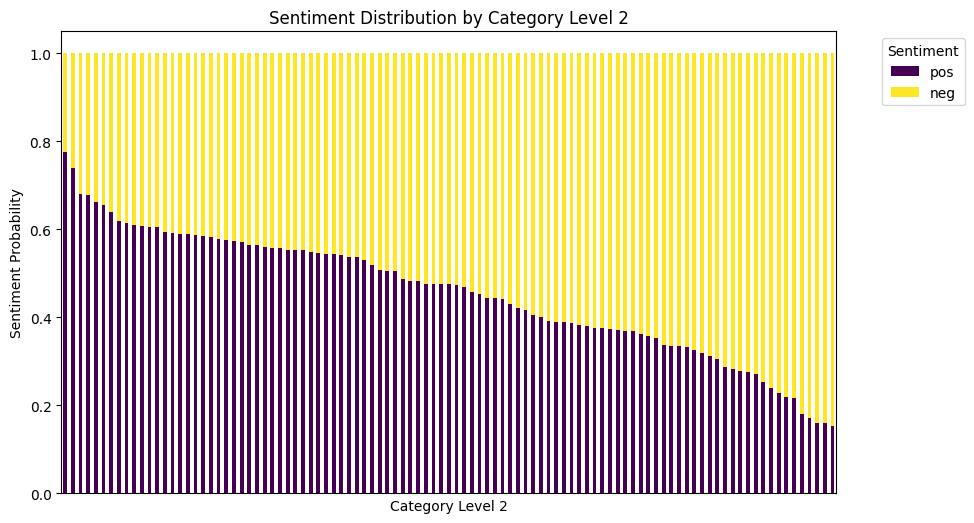

In [ ]:
temp = temp.drop(columns=['sentiment'])
temp[['neg', 'pos']] = temp[['neg', 'pos']].div(temp[['neg', 'pos']].sum(axis=1), axis=0)

temp = temp.sort_values(by='pos', ascending=False)

# Plotting
ax = temp.plot(kind='bar',ax=None, stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Sentiment Distribution by Category Level 2')
ax.set_xticks([])
plt.xlabel('Category Level 2')
plt.ylabel('Sentiment Probability')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
print("Two most positive topics are: ")
temp.category_lvl2.iloc[:2]

Two most positive topics are: 


65    Musical genres styles eras and events
23                         Computing People
Name: category_lvl2, dtype: object

In [ ]:
print("The most negative topics are: ")
temp.category_lvl2.iloc[-5:]

The most negative topics are: 


99          World War II
82        Recent History
79     Pre 1900 Military
67     Natural Disasters
25    Conflict and Peace
Name: category_lvl2, dtype: object

There appear to be multiple topics having extreme sentiment scores, especially negative topics at this level. In fact, these negative topics are about War and Disaster so it is reasonable that they are more negative.